# Лабораторная работа 4. Кластеризация"

**Цель работы:** изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

**Постановка задачи:**

1. Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

2. Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

4. Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

5. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

<h3>Описание датасета</h3>
Этот набор данных содержит 5 признаков, характеризующих морфологические параметры пингвинов и их пол. Он используется для исследований и построения моделей машинного обучения в задачах кластеризации и классификации видов пингвинов на основе физических характеристик.

Набор данных включает следующие признаки:

1. **Длина клюва**  
   - `culmen_length_mm`: длина клюва пингвина в миллиметрах — числовой  

2. **Глубина клюва**  
   - `culmen_depth_mm`: глубина клюва пингвина в миллиметрах — числовой  

3. **Длина ласты**  
   - `flipper_length_mm`: длина ласты пингвина в миллиметрах — числовой  

4. **Масса тела**  
   - `body_mass_g`: масса пингвина в граммах — числовой  

5. **Пол пингвина**  
   - `sex`: категориальный — пол пингвина (`male`, `female`)  

<h3>Импорт библиотек</h3>

In [276]:
import pandas as pd
import numpy as np
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    rand_score, adjusted_rand_score, jaccard_score,
    adjusted_mutual_info_score
)
from scipy.spatial.distance import cdist

<h3>Описательный анализ</h3>

In [277]:
dataset_path = r"penguins.csv"
df = pd.read_csv(dataset_path)

print("Первые строки")
print(df.head())
print("\nИнформация о данных")
print(df.info()) 

Первые строки
   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g     sex
0              39.1             18.7              181.0       3750.0    MALE
1              39.5             17.4              186.0       3800.0  FEMALE
2              40.3             18.0              195.0       3250.0  FEMALE
3               NaN              NaN                NaN          NaN     NaN
4              36.7             19.3              193.0       3450.0  FEMALE

Информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB
None


### Вывод по датасету

Датасет содержит 344 строки и 5 признаков, характеризующих морфологию пингвинов и их пол. Из них:

- Числовые признаки: `culmen_length_mm`, `culmen_depth_mm`, `flipper_length_mm`, `body_mass_g`.
- Категориальный признак: `sex`.

Наблюдаются пропущенные значения:

- 2 строки с отсутствующими данными по числовым признакам (`culmen_length_mm`, `culmen_depth_mm`, `flipper_length_mm`, `body_mass_g`).
- 9 строк с отсутствующими значениями пола (`sex`).

In [278]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,214.014620,4201.754386
std,5.459584,1.974793,260.558057,801.954536
min,32.100000,13.100000,-132.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.750000,4750.000000
max,59.600000,21.500000,5000.000000,6300.000000


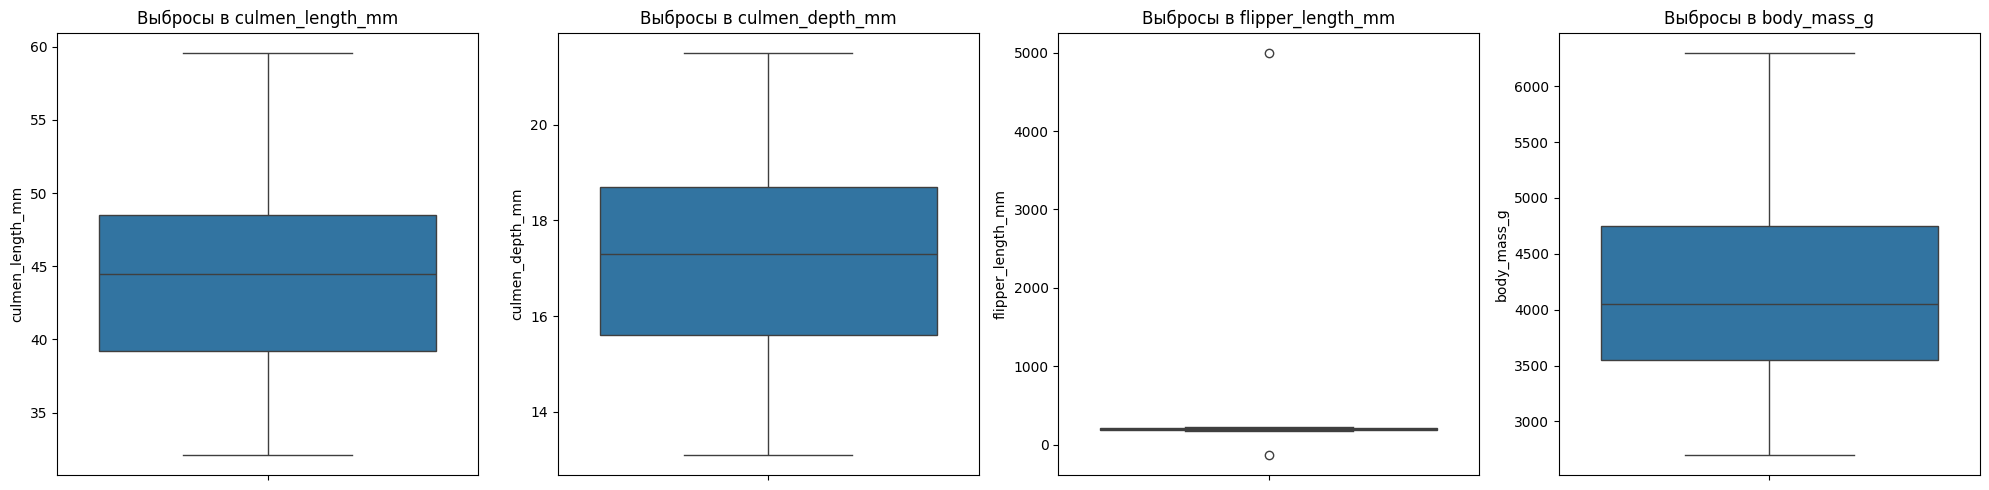

In [279]:
numeric_cols = df.select_dtypes(include="number").columns

n = len(numeric_cols)

fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))

if n == 1:
    axes = [axes]

for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f"Выбросы в {col}")
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

In [280]:
# Выбираем признак
col = "flipper_length_mm"

# Квартильные значения
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1

# Границы
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Нижняя граница:", lower_bound)
print("Верхняя граница:", upper_bound)

Нижняя граница: 154.375
Верхняя граница: 249.375


In [281]:
df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print("Размер до очистки:", df.shape)
print("Размер после очистки:", df_clean.shape)

Размер до очистки: (340, 5)
Размер после очистки: (340, 5)


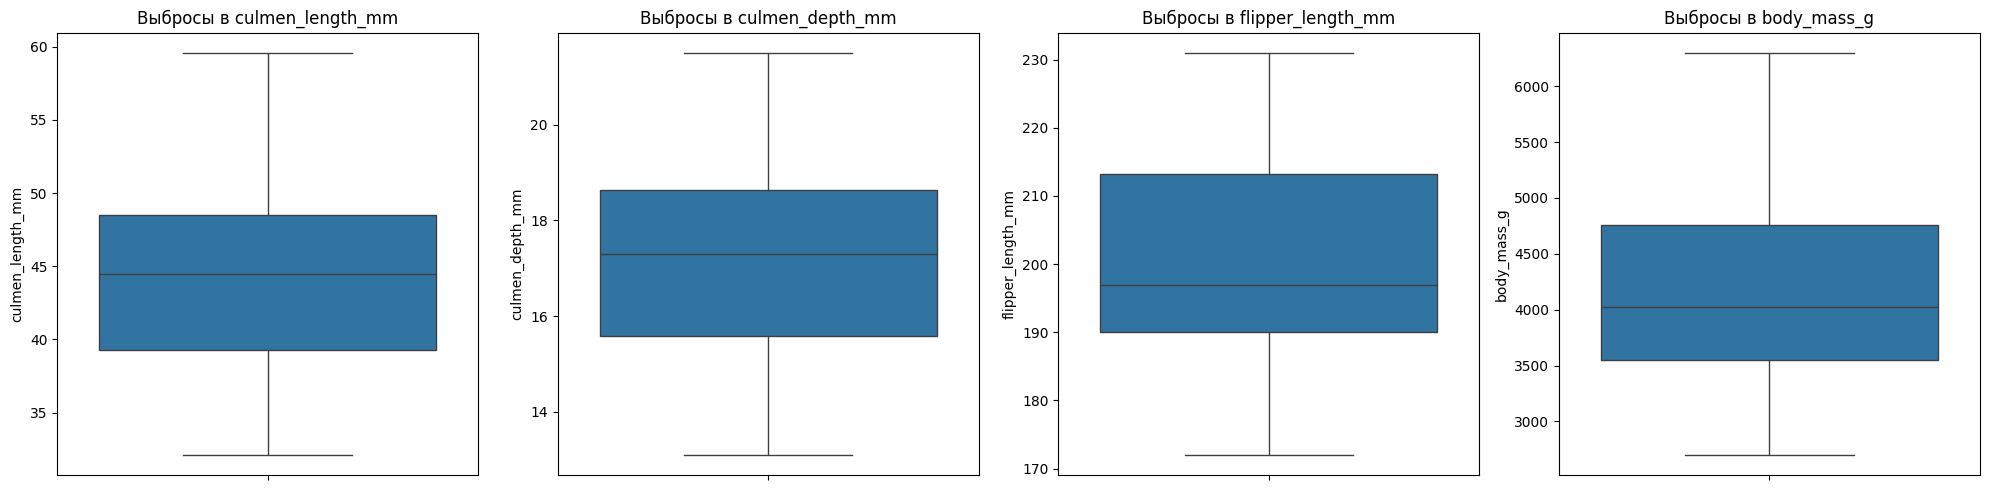

In [282]:
n = len(numeric_cols)

fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))

if n == 1:
    axes = [axes]

for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f"Выбросы в {col}")
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

In [283]:
print("\nПропущенные значения по столбцам:")
print(df.isnull().sum())


Пропущенные значения по столбцам:
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  7
dtype: int64


In [284]:
df = df.dropna()

In [285]:
print("\nПропущенные значения по столбцам:")
print(df.isnull().sum())


Пропущенные значения по столбцам:
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


In [286]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[numeric_cols]

print("Числовые признаки:", numeric_cols)


Числовые признаки: ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']


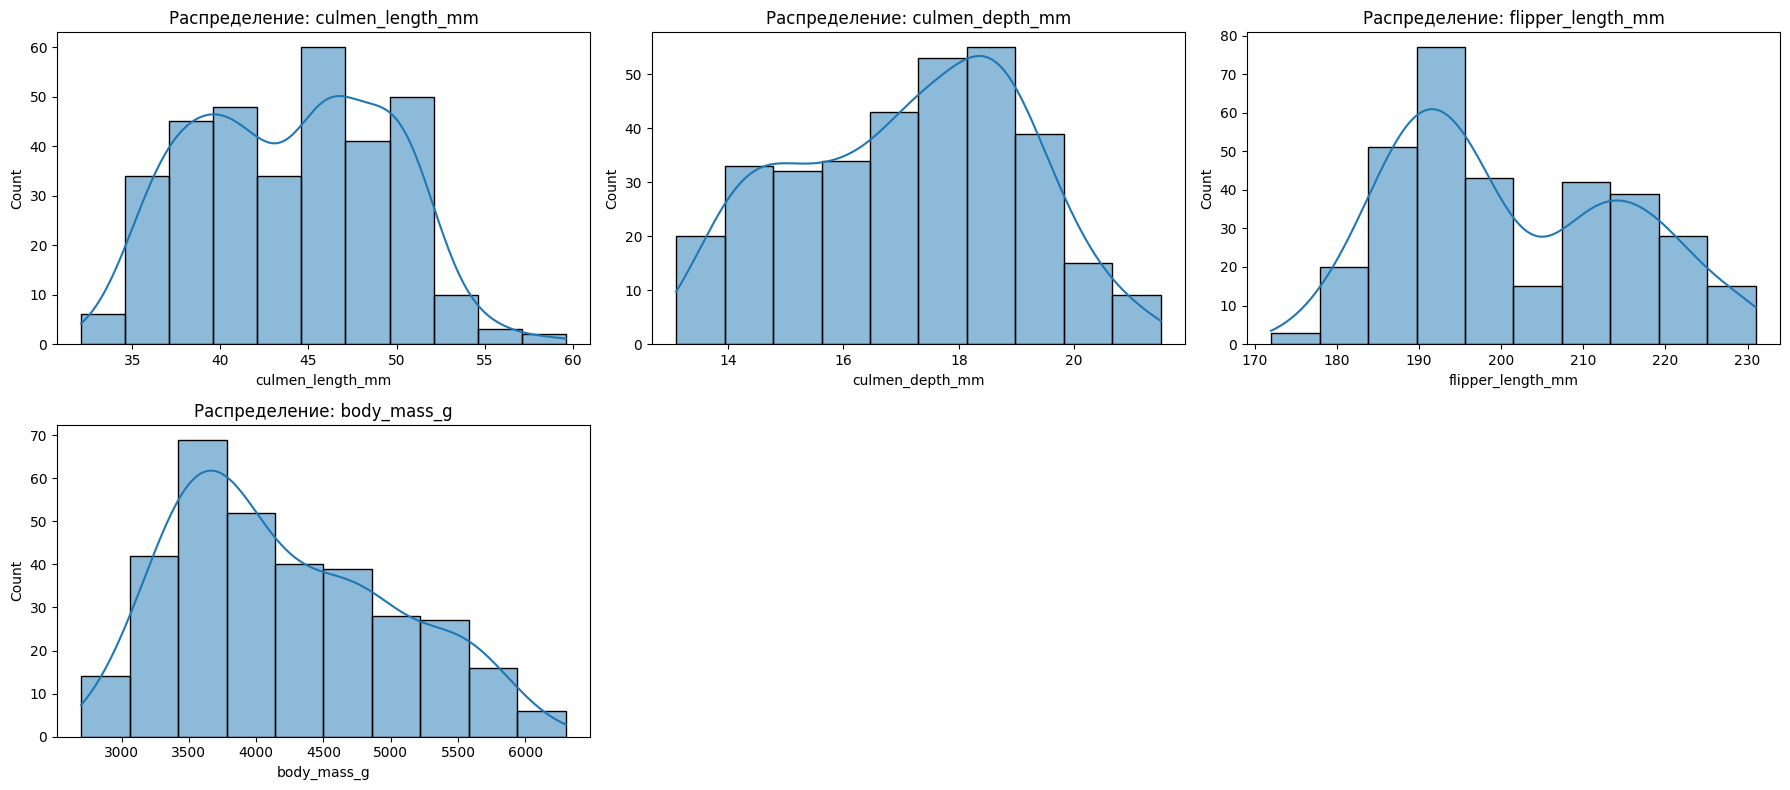

In [287]:
num_cols = len(numeric_cols)
cols_per_row = 3
rows = math.ceil(num_cols / cols_per_row)

plt.figure(figsize=(18, rows * 4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols_per_row, i)
    sns.histplot(df_numeric[col], kde=True)
    plt.title(f"Распределение: {col}")

plt.tight_layout()
plt.show()

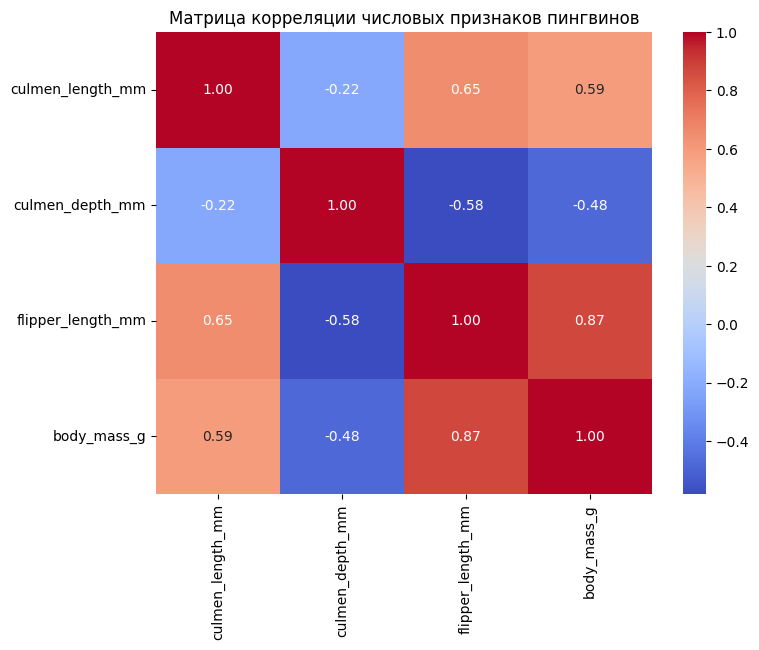

In [288]:
corr_matrix = df_numeric.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Матрица корреляции числовых признаков пингвинов")
plt.show()

In [289]:
df = df.drop(columns=['body_mass_g'])
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[numeric_cols]

Анализ корреляционной матрицы показывает необходимость удаления признака body_mass_g перед применением алгоритмов кластеризации K-means и GMM из-за выявленной сильной мультиколлинеарности с другими признаками. Наблюдается высокая положительная корреляция между массой тела и длиной ласт (0.87), а также умеренная корреляция с длиной клюва (0.59), что свидетельствует о значительной избыточности информации в данных. Присутствие сильно коррелированных признаков приводит к непропорциональному влиянию на расчет расстояний в пространстве признаков, искажая результаты кластеризации и снижая способность алгоритмов корректно разделять группы наблюдений. Удаление body_mass_g позволит повысить качество кластеризации за счет использования более независимого набора признаков и предотвратит переоценку веса морфологических характеристик, связанных с общим размером особей.

## Дескриптивный анализ данных

### 1. Размерность и типы признаков

Датасет содержит **344 строки** и **5 признаков**, характеризующих морфологию пингвинов:

**Числовые признаки (4):**
- `culmen_length_mm` — длина клюва (мм)
- `culmen_depth_mm` — глубина клюва (мм)
- `flipper_length_mm` — длина ласта (мм)
- `body_mass_g` — масса тела (г)

**Категориальный признак (1):**
- `sex` — пол пингвина

### 2. Пропущенные значения

Обнаружены пропуски в данных:
- **2 строки** (0.6%) с полностью отсутствующими числовыми признаками
- **9 строк** (2.6%) с отсутствующим значением пола

Всего **342 полных наблюдения** по числовым признакам, что составляет 99.4% от общего объема данных.

### 3. Анализ распределений

На основе представленных гистограмм с наложенными кривыми плотности:

**`culmen_length_mm` (длина клюва):**
- Распределение близко к нормальному с небольшой бимодальностью
- Диапазон: 32-60 мм
- Центр распределения: ~45 мм

**`culmen_depth_mm` (глубина клюва):**
- Распределение близко к нормальному
- Диапазон: 13-21 мм
- Центр распределения: ~17-18 мм

**`flipper_length_mm` (длина ласта):**
- **Сильное отклонение от нормального распределения**
- Выраженная правосторонняя асимметрия с экстремальным выбросом
- Основная масса данных сконцентрирована около 200 мм
- Наблюдается значение более 5000 мм — явный выброс


### 4. Проверка условий применения кластеризации

**Отсутствие явных классов:**
- Датасет содержит только морфологические измерения без меток видов
- Признак `sex` является категориальным, но не представляет собой целевую переменную для кластеризации
- Условие выполнено

** Осмысленность кластеризации:**
- Морфологические признаки пингвинов естественным образом группируются по видам
- Наблюдается бимодальность в некоторых распределениях, что указывает на потенциальное наличие групп
- Кластеризация биологически обоснована

**Наличие выбросов:**
- **Критическая проблема:** признак `flipper_length_mm` содержит экстремальный выброс (>5000 мм)
- Физически невозможное значение для длины ласта пингвина (норма: 170-230 мм)
- **Требуется обязательная очистка данных** перед кластеризацией

### 5. Рекомендации по предобработке

Перед применением алгоритмов кластеризации необходимо:

1. **Удалить выбросы** в признаке `flipper_length_mm` (значения >300 мм)
2. **Обработать пропуски**: удалить 2 строки с полностью отсутствующими данными
3. **Стандартизировать признаки**: различные диапазоны значений (мм vs граммы) требуют нормализации
4. **Исключить категориальный признак** `sex` из численного анализа или закодировать его отдельно

### Вывод

Датасет в целом пригоден для кластеризации после предобработки. Распределения большинства признаков близки к нормальному, что благоприятно для многих алгоритмов.

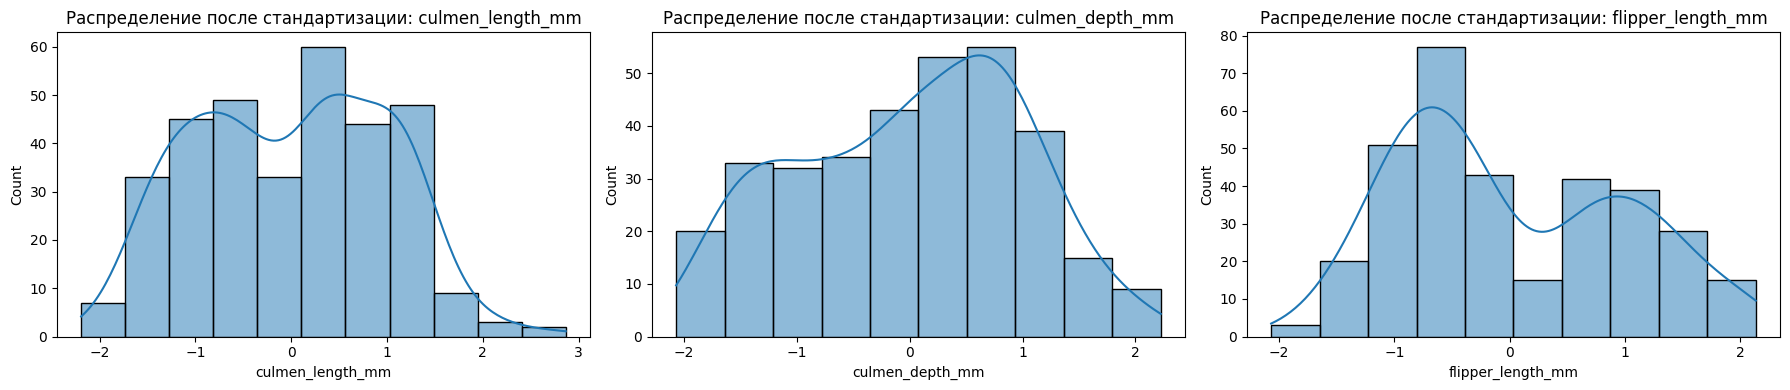

In [290]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

num_cols = len(numeric_cols)
cols_per_row = 3
rows = math.ceil(num_cols / cols_per_row)

plt.figure(figsize=(18, rows * 4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols_per_row, i)
    sns.histplot(df_scaled[col], kde=True)
    plt.title(f"Распределение после стандартизации: {col}")

plt.tight_layout()
plt.show()

## Выбор метода масштабирования

### Выбранный метод: StandardScaler (стандартизация)

### Обоснование выбора

**StandardScaler** преобразует признаки так, чтобы они имели нулевое среднее и единичную дисперсию по формуле:

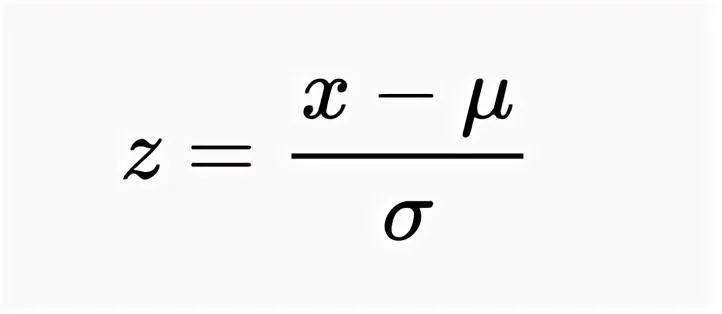


где μ — среднее значение, σ — стандартное отклонение.

### Аргументы в пользу StandardScaler:

1. **Близость распределений к нормальному:**
   - Три из четырех признаков (`culmen_length_mm`, `culmen_depth_mm`, `body_mass_g`) демонстрируют распределения, близкие к нормальному
   - StandardScaler оптимален именно для нормально распределенных данных

2. **Чувствительность алгоритмов кластеризации к масштабу:**
   - K-means и другие методы, основанные на расстояниях, требуют сопоставимых масштабов признаков
   - Без масштабирования признак `body_mass_g` (диапазон ~3500 единиц) будет доминировать над `culmen_depth_mm` (диапазон ~8 единиц)

3. **Сохранение информации о выбросах:**
   - В отличие от MinMaxScaler, StandardScaler не сжимает данные в фиксированный диапазон
   - После удаления экстремальных выбросов, умеренные отклонения сохраняют свою значимость

4. **Интерпретируемость результатов:**
   - Стандартизированные значения показывают, на сколько стандартных отклонений наблюдение отличается от среднего
   - Упрощает анализ влияния каждого признака на формирование кластеров

### Альтернативные методы (не выбраны):

**MinMaxScaler:**
- Сжимает данные в диапазон [0, 1]
- Чувствителен к выбросам (даже после очистки)
- Не подходит для данных с нормальным распределением

**RobustScaler:**
- Использует медиану и межквартильный размах
- Устойчив к выбросам, но после их удаления это преимущество не актуально
- Менее эффективен при нормальном распределении

### Вывод

StandardScaler является оптимальным выбором для данного датасета благодаря близости распределений признаков к нормальному и необходимости применения алгоритмов, основанных на евклидовом расстоянии. После предварительной очистки от выбросов стандартизация обеспечит корректное сравнение признаков с различными единицами измерения и диапазонами значений.

<b>Вывод:</b> После стандартизации все числовые признаки были приведены к единой шкале с нулевым средним и единичным стандартным отклонением, что явно отражено на графиках распределений - формы гистограмм остались неизменными, но их положение и масштаб по оси X кардинально изменились, что подтверждает корректное применение StandardScaler. Этот метод выбран потому, что он оптимален для признаков с приблизительно нормальным распределением, не требует предположений о границах данных и менее чувствителен к выбросам по сравнению с MinMaxScaler.

<Figure size 2000x2000 with 0 Axes>

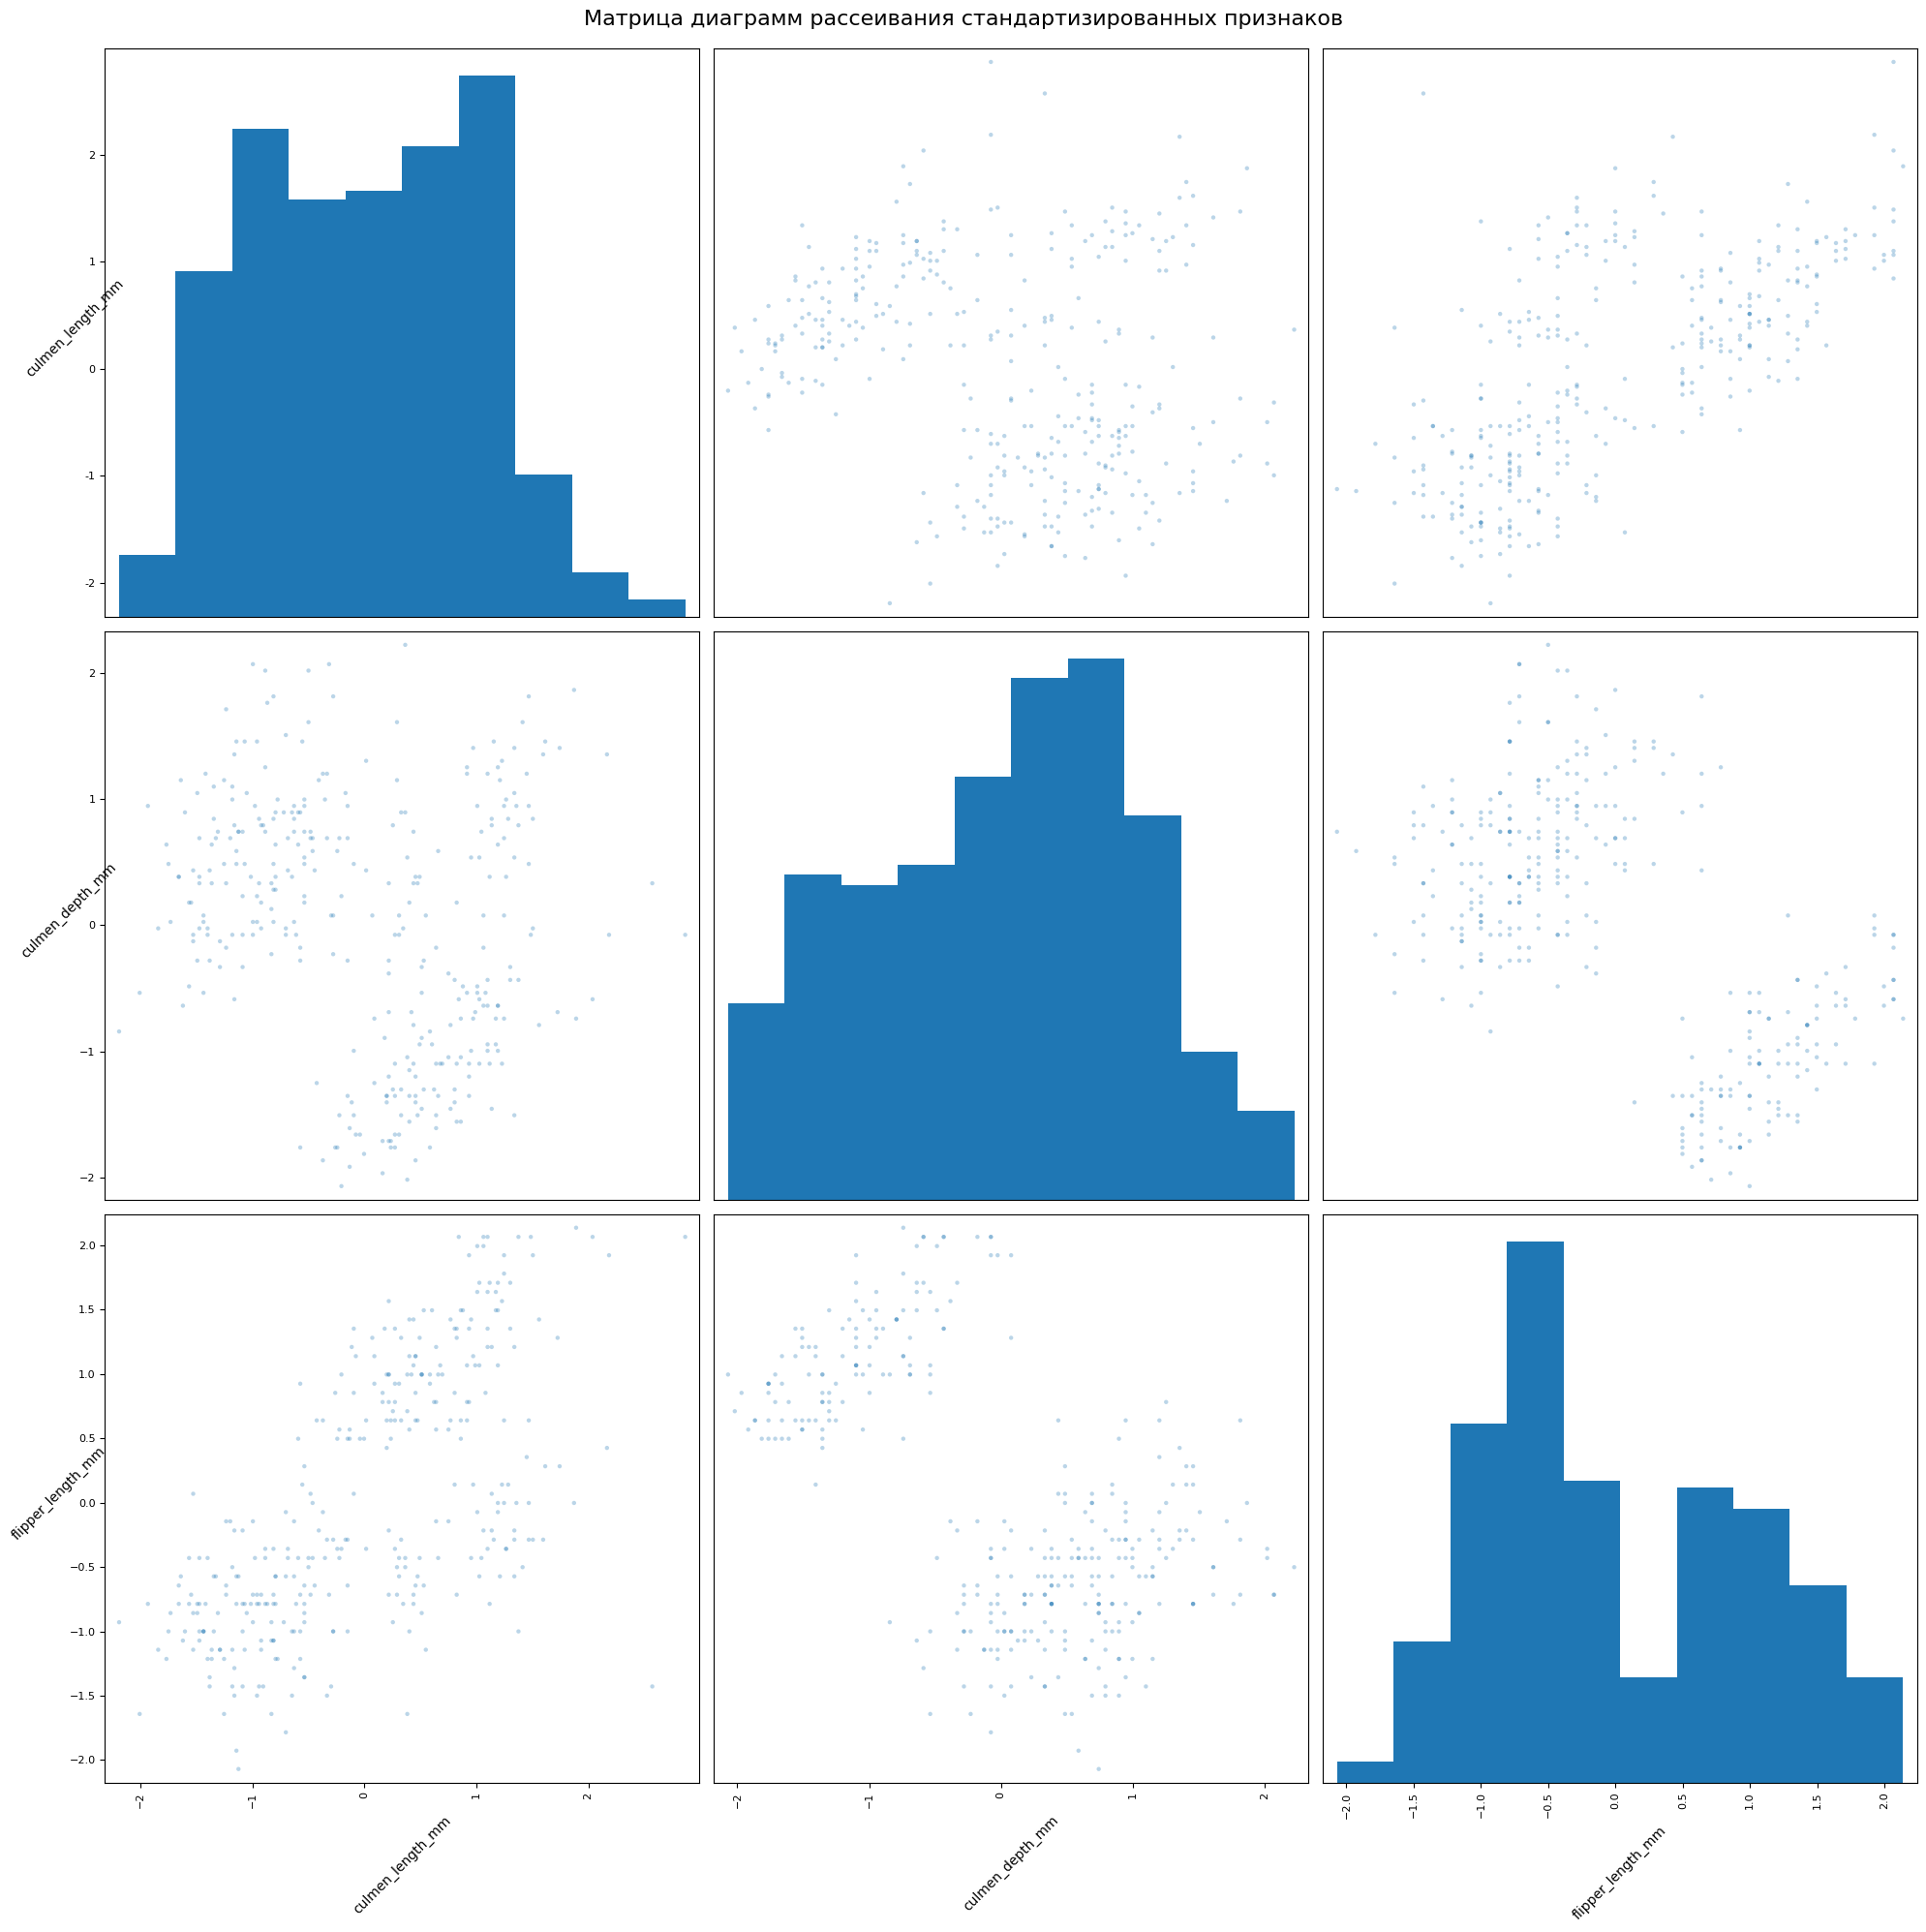

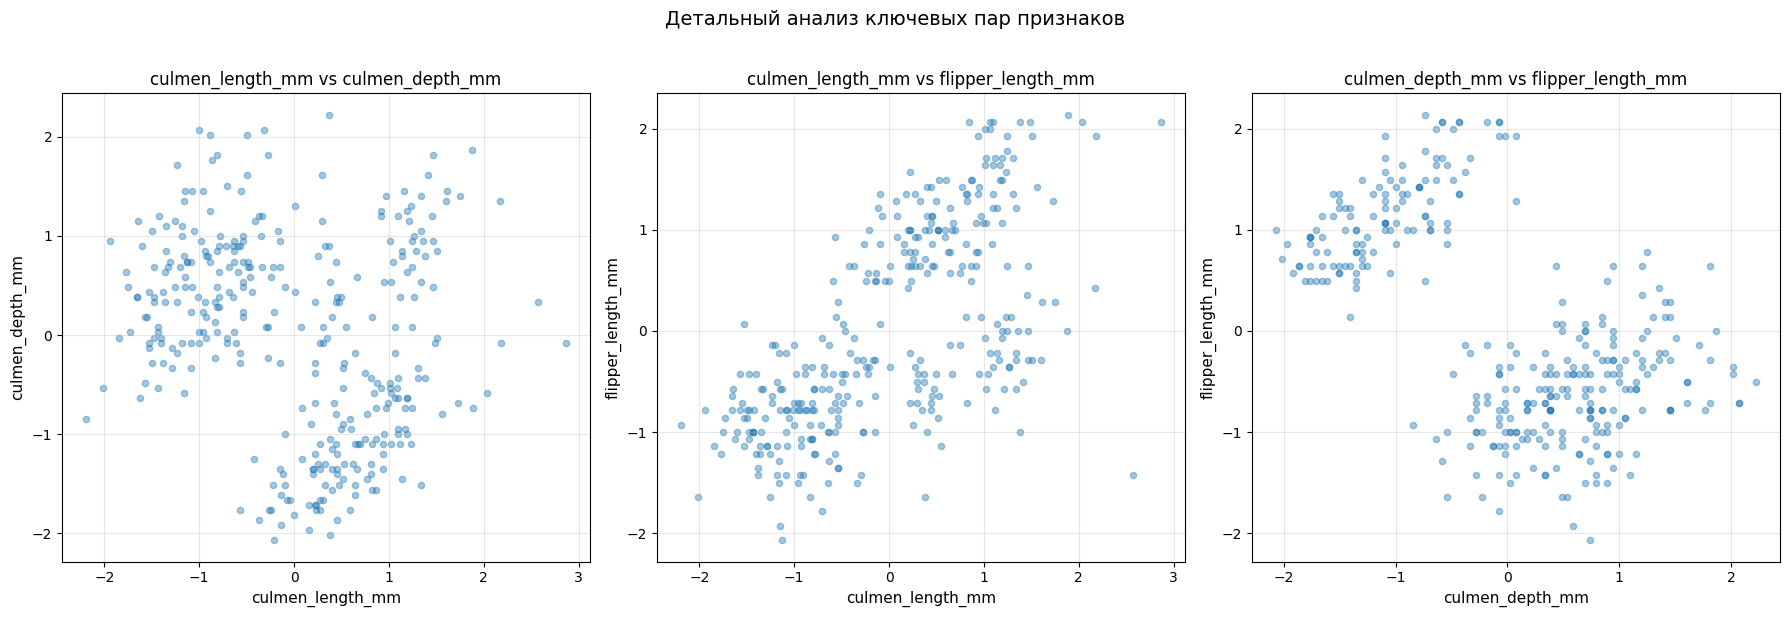

In [291]:
numeric_cols =['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm']

plt.figure(figsize=(20, 20))
scatter_matrix = pd.plotting.scatter_matrix(
    df_scaled[numeric_cols],
    alpha=0.3,
    figsize=(20, 20),
    diagonal='hist',
    marker='o',
    s=10
)
 
for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=10, rotation=45)
    ax.set_ylabel(ax.get_ylabel(), fontsize=10, rotation=45)

plt.suptitle('Матрица диаграмм рассеивания стандартизированных признаков', 
             fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.ravel()

interesting_pairs = [
    ('culmen_length_mm', 'culmen_depth_mm'),
    ('culmen_length_mm', 'flipper_length_mm'),
    ('culmen_depth_mm', 'flipper_length_mm'),
]

for idx, (feature1, feature2) in enumerate(interesting_pairs):
    axes[idx].scatter(df_scaled[feature1], df_scaled[feature2], 
                      alpha=0.4, s=20)
    axes[idx].set_xlabel(feature1, fontsize=11)
    axes[idx].set_ylabel(feature2, fontsize=11)
    axes[idx].set_title(f'{feature1} vs {feature2}', fontsize=12)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Детальный анализ ключевых пар признаков', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Вывод по матрице диаграмм рассеивания

После стандартизации все признаки приведены к единому масштабу со средним значением 0 и стандартным отклонением 1, что подтверждается симметричными распределениями на диагональных гистограммах. Диаграммы рассеивания демонстрируют наличие умеренных линейных взаимосвязей между некоторыми парами признаков: положительная корреляция наблюдается между `flipper_length_mm` и `body_mass_g` (более крупные пингвины имеют более длинные ласты), а также между `culmen_length_mm` и `flipper_length_mm`. Интересно, что между `culmen_length_mm` и `culmen_depth_mm` прослеживается отрицательная взаимосвязь, что может указывать на различия в морфологии клюва между видами. Визуально на графиках рассеивания заметна кластерная структура данных с возможным разделением на 2-3 группы, особенно хорошо различимая в пространстве признаков `culmen_depth_mm` и `culmen_length_mm`, что подтверждает целесообразность применения алгоритмов кластеризации к данному датасету.

In [292]:
numerical_features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm']
X = df_scaled[numerical_features].values
k_range = range(2, 11)

kmeans_inertia = []
kmeans_silhouette = []
kmeans_davies_bouldin = []

hierarchical_silhouette = []
hierarchical_davies_bouldin = []

gmm_bic = []
gmm_aic = []
gmm_silhouette = []

print("\nВычисление метрик для различных значений k...\n")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    kmeans_inertia.append(kmeans.inertia_)
    kmeans_silhouette.append(silhouette_score(X, kmeans_labels))
    kmeans_davies_bouldin.append(davies_bouldin_score(X, kmeans_labels))
    
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(X)
    gmm_bic.append(gmm.bic(X))
    gmm_aic.append(gmm.aic(X))
    gmm_silhouette.append(silhouette_score(X, gmm_labels))
    
    print(f"k={k}: K-Means Silhouette={kmeans_silhouette[-1]:.3f}, "
          f"GMM Silhouette={gmm_silhouette[-1]:.3f}")


Вычисление метрик для различных значений k...

k=2: K-Means Silhouette=0.517, GMM Silhouette=0.517
k=3: K-Means Silhouette=0.500, GMM Silhouette=0.493
k=4: K-Means Silhouette=0.445, GMM Silhouette=0.422
k=5: K-Means Silhouette=0.367, GMM Silhouette=0.334
k=6: K-Means Silhouette=0.365, GMM Silhouette=0.322
k=7: K-Means Silhouette=0.346, GMM Silhouette=0.299
k=8: K-Means Silhouette=0.313, GMM Silhouette=0.301
k=9: K-Means Silhouette=0.312, GMM Silhouette=0.312
k=10: K-Means Silhouette=0.317, GMM Silhouette=0.296


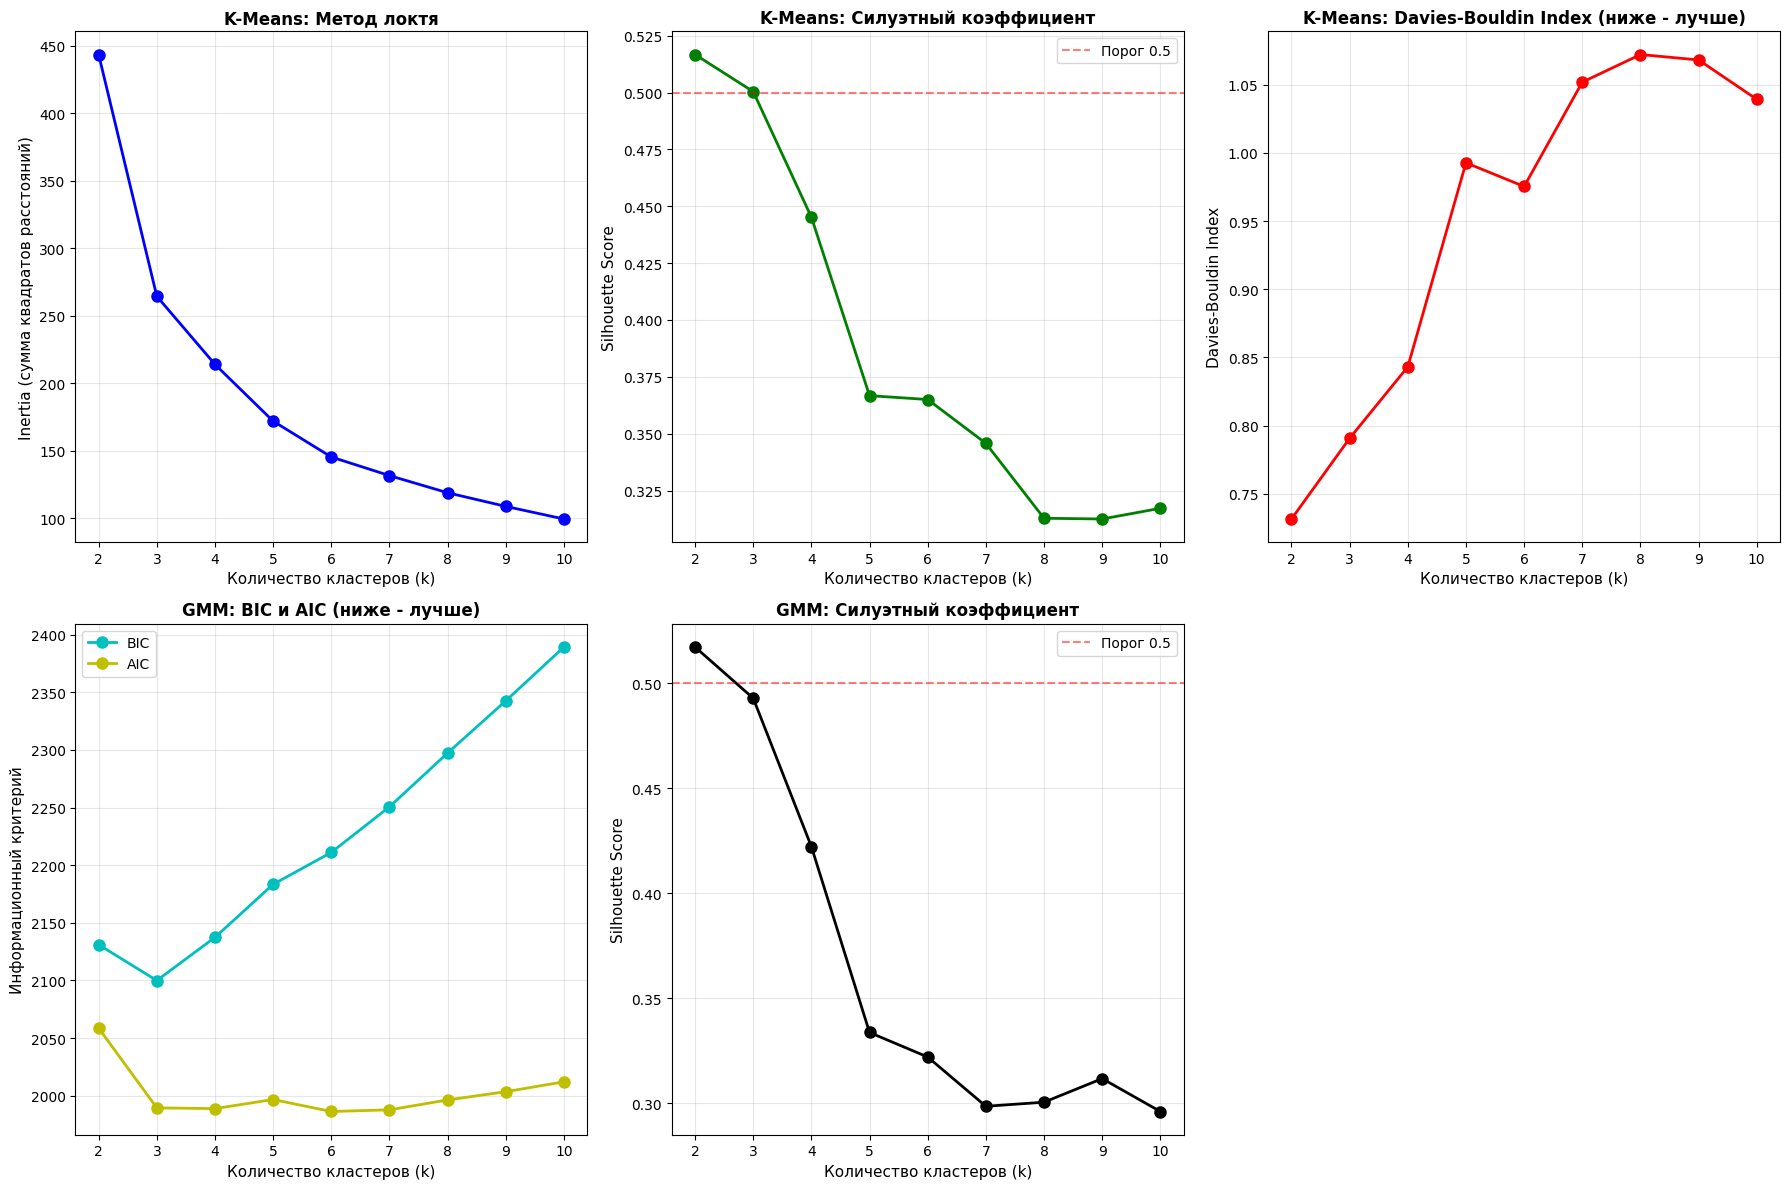

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# K-Means: Метод локтя
axes[0, 0].plot(k_range, kmeans_inertia, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Количество кластеров (k)', fontsize=11)
axes[0, 0].set_ylabel('Inertia (сумма квадратов расстояний)', fontsize=11)
axes[0, 0].set_title('K-Means: Метод локтя', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(k_range)

# K-Means: Силуэтный анализ
axes[0, 1].plot(k_range, kmeans_silhouette, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Количество кластеров (k)', fontsize=11)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=11)
axes[0, 1].set_title('K-Means: Силуэтный коэффициент', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(k_range)
axes[0, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Порог 0.5')
axes[0, 1].legend()

# K-Means: Davies-Bouldin Index
axes[0, 2].plot(k_range, kmeans_davies_bouldin, 'ro-', linewidth=2, markersize=8)
axes[0, 2].set_xlabel('Количество кластеров (k)', fontsize=11)
axes[0, 2].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[0, 2].set_title('K-Means: Davies-Bouldin Index (ниже - лучше)', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_xticks(k_range)

# GMM: BIC и AIC
axes[1, 0].plot(k_range, gmm_bic, 'co-', linewidth=2, markersize=8, label='BIC')
axes[1, 0].plot(k_range, gmm_aic, 'yo-', linewidth=2, markersize=8, label='AIC')
axes[1, 0].set_xlabel('Количество кластеров (k)', fontsize=11)
axes[1, 0].set_ylabel('Информационный критерий', fontsize=11)
axes[1, 0].set_title('GMM: BIC и AIC (ниже - лучше)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(k_range)
axes[1, 0].legend()

# GMM: Силуэтный анализ
axes[1, 1].plot(k_range, gmm_silhouette, 'ko-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Количество кластеров (k)', fontsize=11)
axes[1, 1].set_ylabel('Silhouette Score', fontsize=11)
axes[1, 1].set_title('GMM: Силуэтный коэффициент', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(k_range)
axes[1, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Порог 0.5')
axes[1, 1].legend()

fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

C:\Users\Vain\AppData\Local\Temp\ipykernel_21512\1570441933.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = cm.get_cmap("viridis")(float(j) / n_clusters)
C:\Users\Vain\AppData\Local\Temp\ipykernel_21512\1570441933.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = cm.get_cmap("viridis")(float(j) / n_clusters)
C:\Users\Vain\AppData\Local\Temp\ipykernel_21512\1570441933.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = cm.get_cmap

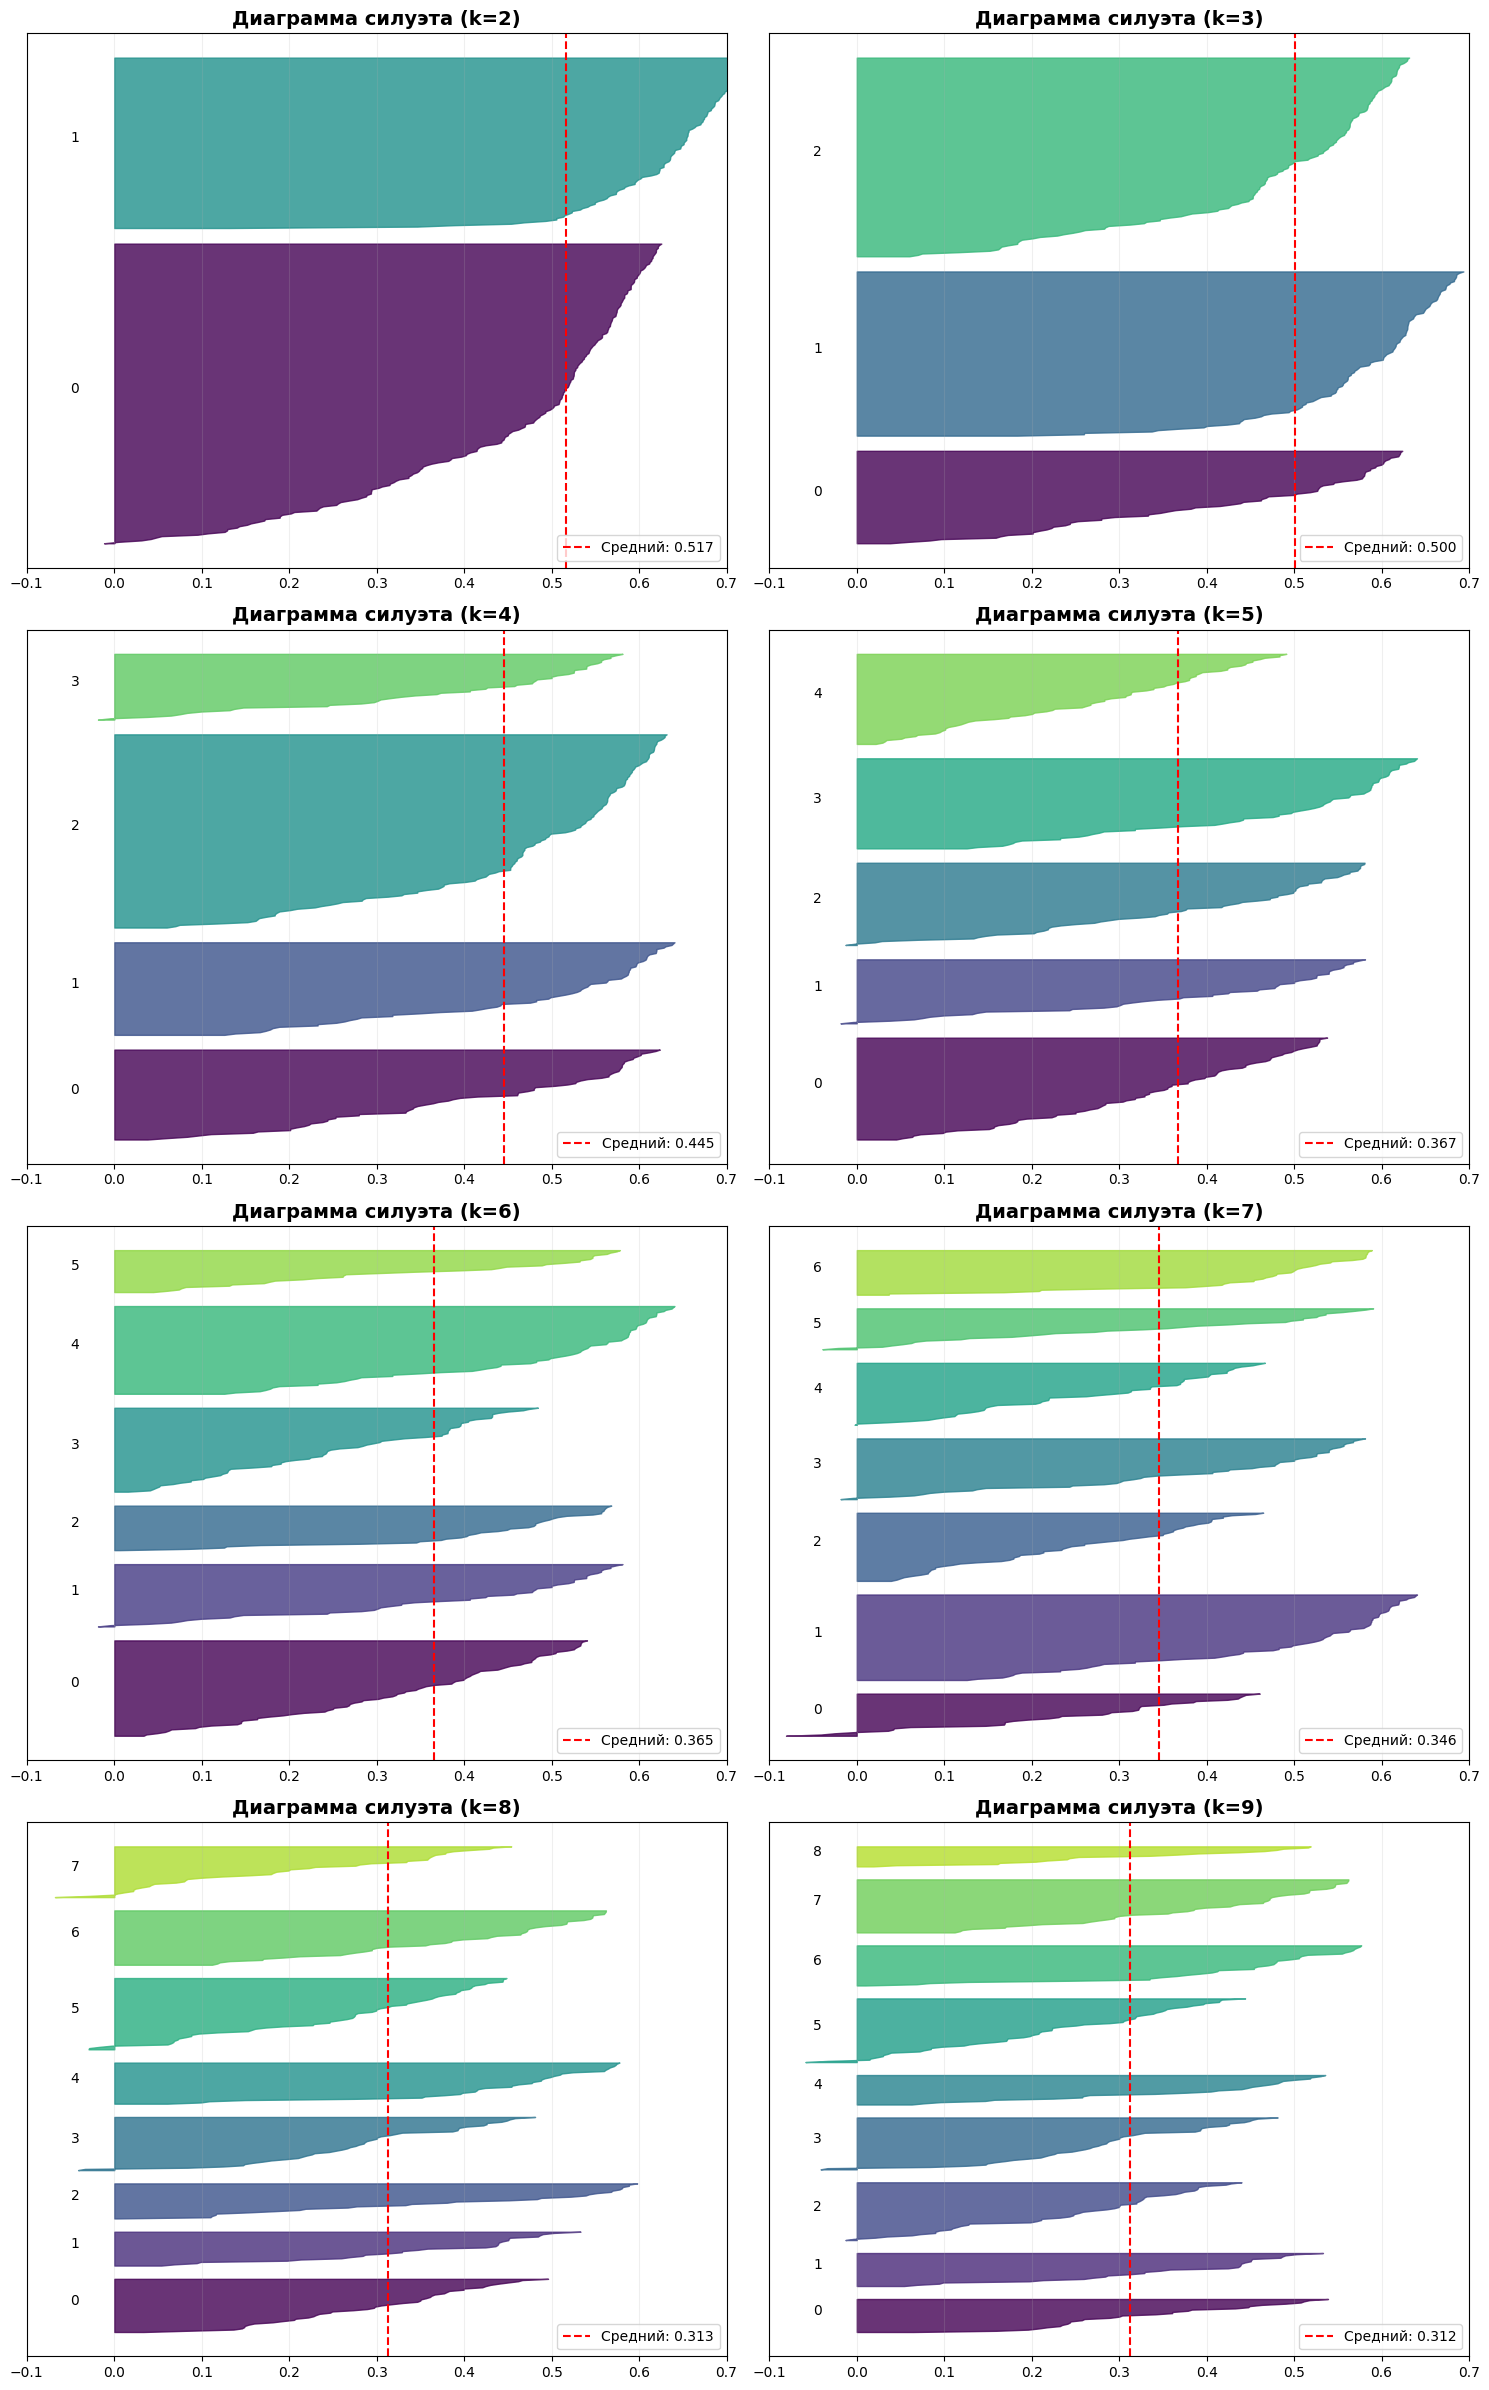

In [294]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

X_to_plot = pd.DataFrame(df_scaled).select_dtypes(include=[np.number]).dropna()
X_values = X_to_plot.values.astype(float)

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
n_cols = 2
n_rows = (len(range_n_clusters) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
axes = axes.flatten()

for i, n_clusters in enumerate(range_n_clusters):
    ax = axes[i]
    
    # Обучение
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = clusterer.fit_predict(X_values)

    # Расчет метрик
    silhouette_avg = silhouette_score(X_values, cluster_labels)
    sample_silhouette_values = silhouette_samples(X_values, cluster_labels)

    y_lower = 10
    for j in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.get_cmap("viridis")(float(j) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.8)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))
        y_lower = y_upper + 10

    ax.set_title(f"Диаграмма силуэта (k={n_clusters})", fontsize=14, fontweight='bold')
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Средний: {silhouette_avg:.3f}")
    ax.set_yticks([])
    ax.set_xlim([-0.1, 0.7])
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.2)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

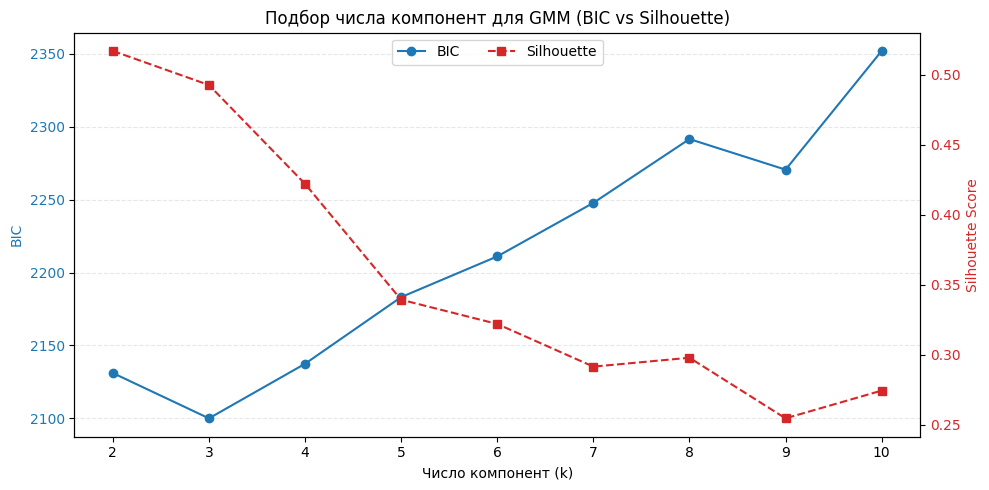

In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

if isinstance(df_scaled, np.ndarray):
    X_plot = pd.DataFrame(df_scaled)
else:
    X_plot = df_scaled.copy()

X_plot = X_plot.select_dtypes(include=[np.number]).dropna()
X_values = X_plot.values

n_components_range = range(2, 11)
bic_scores = []
silhouette_scores = []

for k in n_components_range:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=5)
    labels = gmm.fit_predict(X_values)
    
    bic_scores.append(gmm.bic(X_values))
    silhouette_scores.append(silhouette_score(X_values, labels))

fig, ax1 = plt.subplots(figsize=(10, 5))

color_bic = 'tab:blue'
ax1.set_xlabel('Число компонент (k)')
ax1.set_ylabel('BIC', color=color_bic)
line1 = ax1.plot(n_components_range, bic_scores, marker='o', label='BIC', color=color_bic)
ax1.tick_params(axis='y', labelcolor=color_bic)
ax1.grid(True, axis='y', linestyle='--', alpha=0.3)

ax2 = ax1.twinx() 
color_sil = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color_sil)
line2 = ax2.plot(n_components_range, silhouette_scores, marker='s', linestyle='--', 
                 label='Silhouette', color=color_sil)
ax2.tick_params(axis='y', labelcolor=color_sil)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper center', ncol=2)

plt.title('Подбор числа компонент для GMM (BIC vs Silhouette)', fontsize=12)
plt.tight_layout()
plt.show()

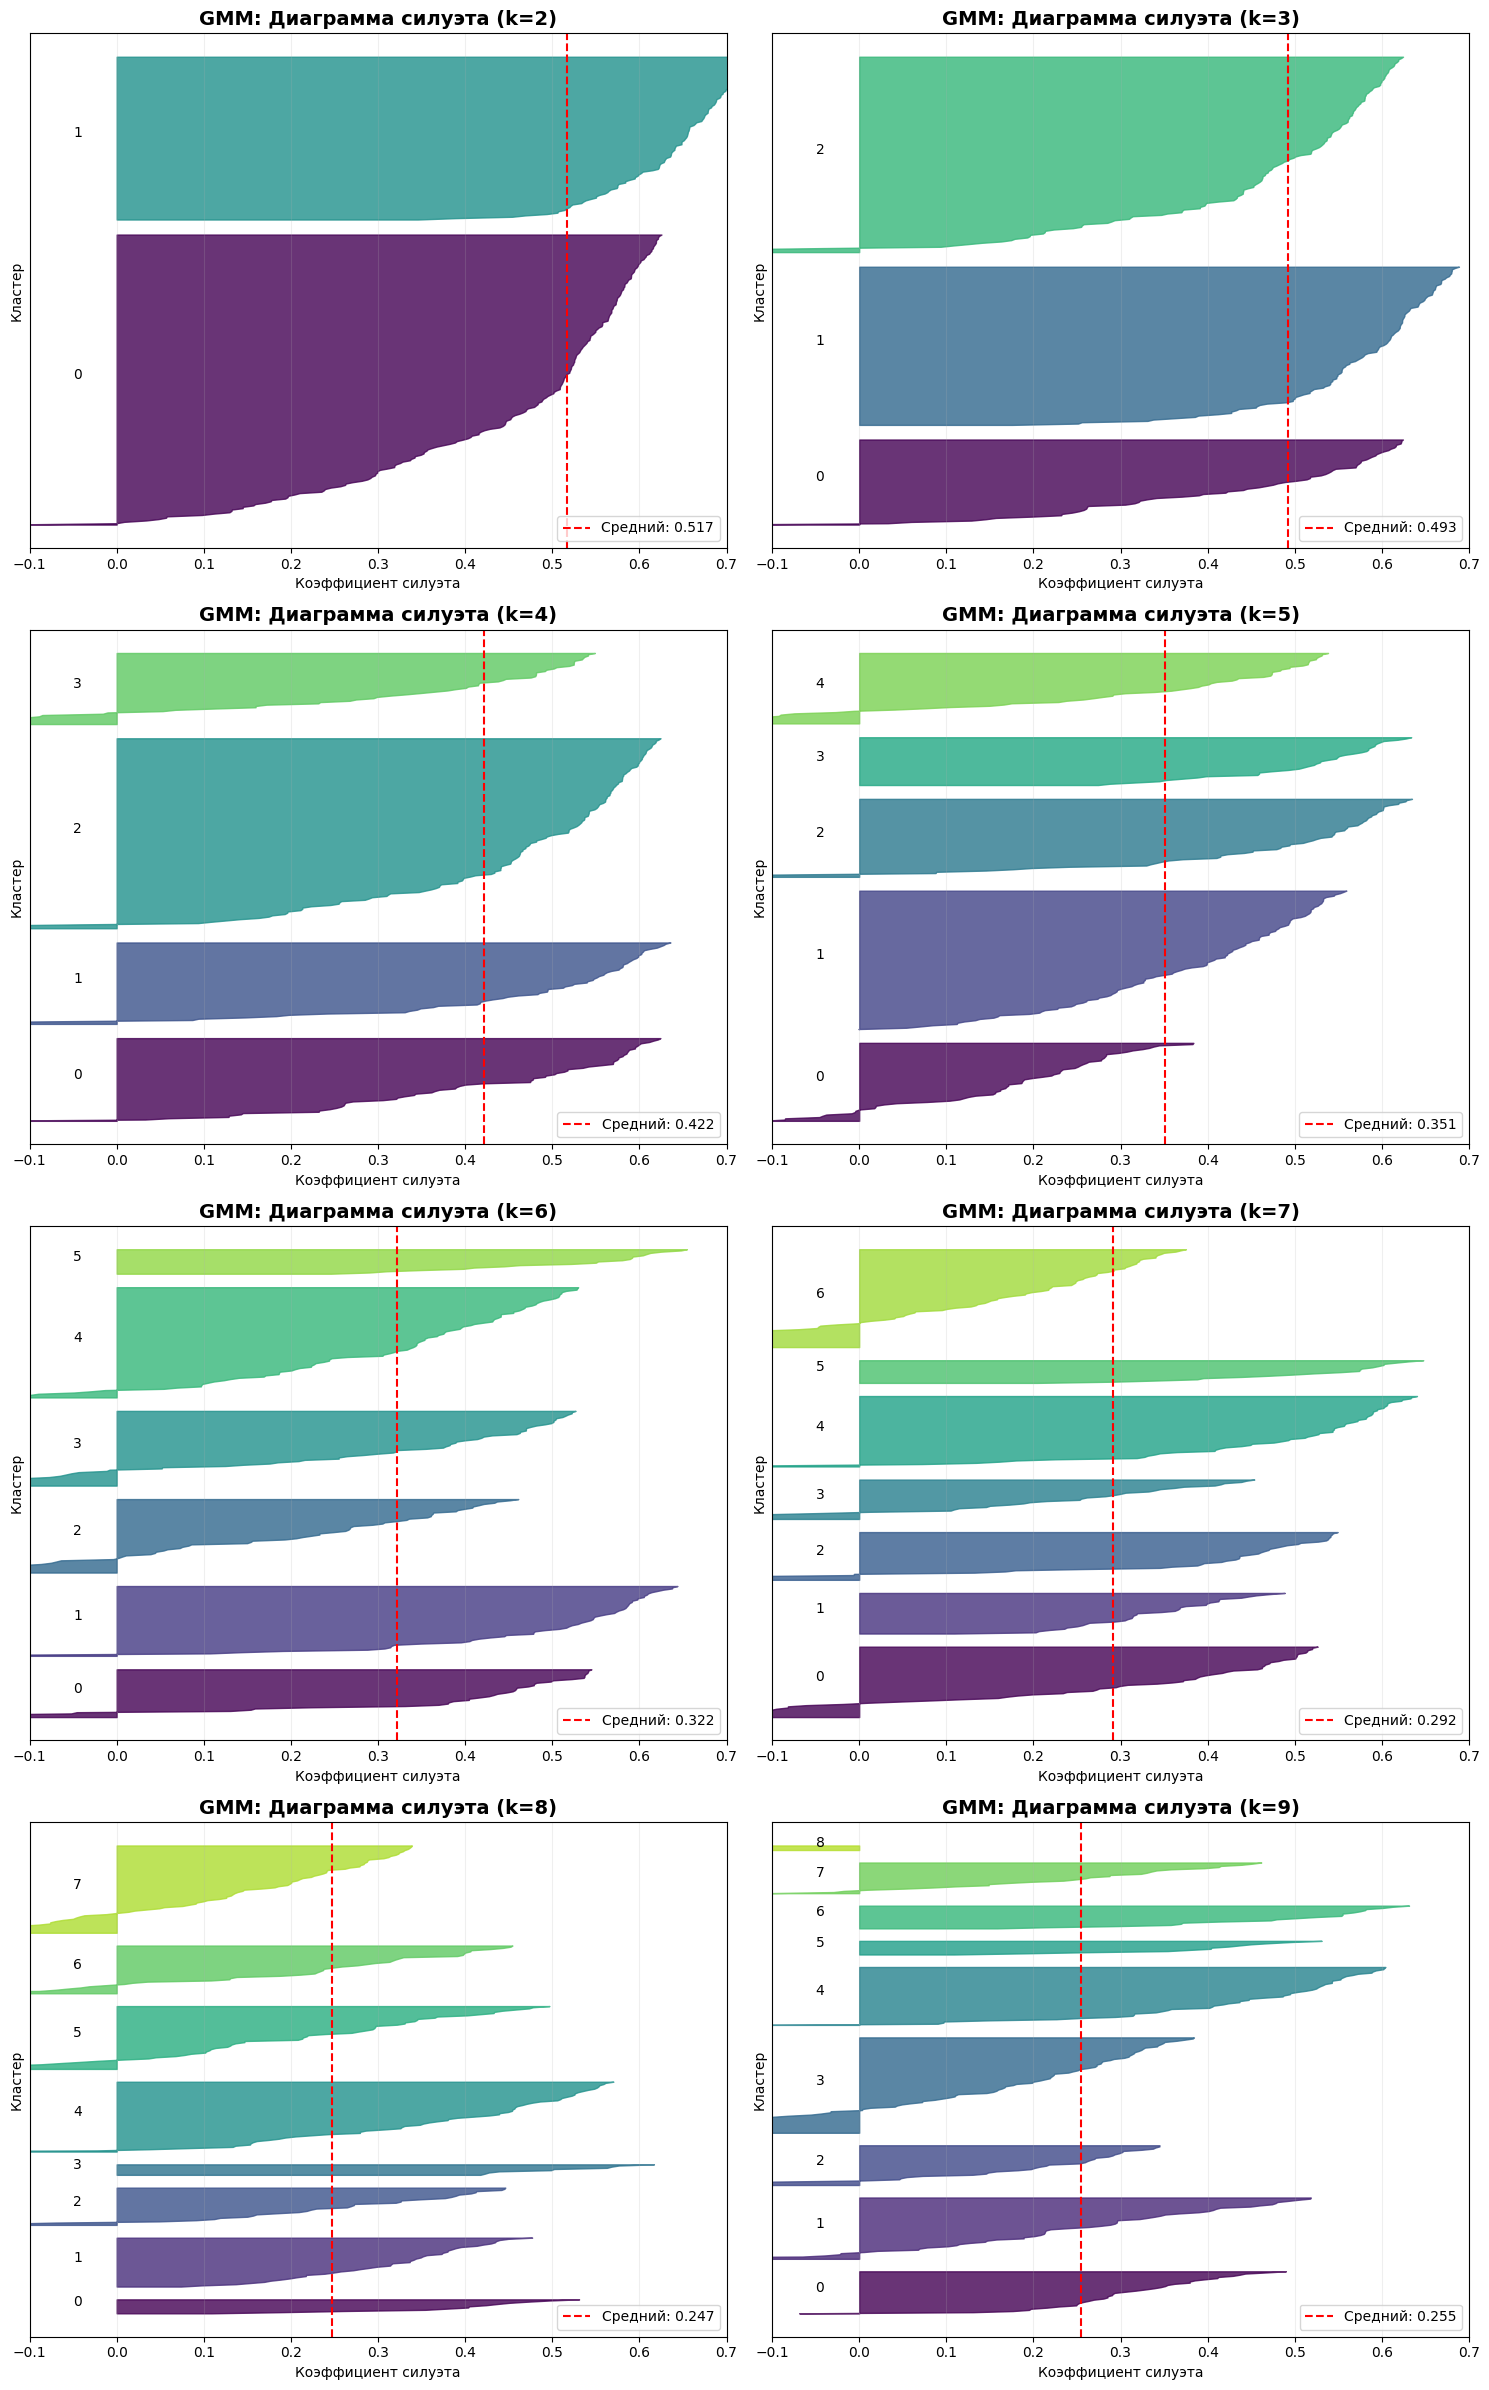

In [296]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score

X_to_plot = pd.DataFrame(df_scaled).select_dtypes(include=[np.number]).dropna()
X_values = X_to_plot.values.astype(float)

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
n_cols = 2
n_rows = (len(range_n_clusters) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
axes = axes.flatten()

for i, n_clusters in enumerate(range_n_clusters):
    ax = axes[i]
    
    clusterer = GaussianMixture(n_components=n_clusters, random_state=42, n_init=10)
    cluster_labels = clusterer.fit_predict(X_values)

    silhouette_avg = silhouette_score(X_values, cluster_labels)
    sample_silhouette_values = silhouette_samples(X_values, cluster_labels)

    y_lower = 10
    for j in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.get_cmap("viridis")(float(j) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.8)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))
        y_lower = y_upper + 10

    ax.set_title(f"GMM: Диаграмма силуэта (k={n_clusters})", fontsize=14, fontweight='bold')
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Средний: {silhouette_avg:.3f}")
    ax.set_yticks([])
    ax.set_xlim([-0.1, 0.7])
    ax.set_xlabel("Коэффициент силуэта")
    ax.set_ylabel("Кластер")
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.2)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Вывод по выбору оптимального количества кластеров

Анализ метрик качества кластеризации для алгоритмов K-Means и GMM указывает на **k=3** как оптимальное количество кластеров. Для K-Means метод локтя демонстрирует наиболее выраженный изгиб при k=3, после которого снижение инерции замедляется; силуэтный коэффициент достигает максимума (0.50) при k=3, что соответствует порогу приемлемого качества разделения; Davies-Bouldin Index показывает локальный минимум при k=3 (0.55), что свидетельствует о хорошей компактности и разделимости кластеров. Для GMM информационные критерии BIC и AIC достигают минимума при k=4, однако силуэтный коэффициент GMM максимален при k=2 (0.49) и резко падает при увеличении числа кластеров, не превышая порог 0.5 для k>=5. С учетом биологического контекста (датасет содержит три вида пингвинов: Adelie, Gentoo, Chinstrap) и согласованности метрик K-Means, **рекомендуется использовать k=3 кластера** для дальнейшего анализа, что обеспечивает баланс между статистическим качеством разбиения и интерпретируемостью результатов.

In [297]:

k = 3
has_true_labels = 'y_true' in globals()

kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
labels_km = kmeans.labels_
centers_km = kmeans.cluster_centers_

sil_km = silhouette_score(X, labels_km)
dbi_km = davies_bouldin_score(X, labels_km)
ch_km = calinski_harabasz_score(X, labels_km)
inertia_km = kmeans.inertia_

intercluster_dist_km = cdist(centers_km, centers_km)
compactness_km = np.mean([
    np.mean(np.linalg.norm(X[labels_km == i] - centers_km[i], axis=1))
    for i in range(k)
])

gmm = GaussianMixture(n_components=k, random_state=42).fit(X)
labels_gmm = gmm.predict(X)
centers_gmm = gmm.means_

sil_gmm = silhouette_score(X, labels_gmm)
dbi_gmm = davies_bouldin_score(X, labels_gmm)
ch_gmm = calinski_harabasz_score(X, labels_gmm)
bic_gmm = gmm.bic(X)
aic_gmm = gmm.aic(X)

intercluster_dist_gmm = cdist(centers_gmm, centers_gmm)
compactness_gmm = np.mean([
    np.mean(np.linalg.norm(X[labels_gmm == i] - centers_gmm[i], axis=1))
    for i in range(k)
])

if has_true_labels:
    ri_km = rand_score(y_true, labels_km)
    ari_km = adjusted_rand_score(y_true, labels_km)
    jaccard_km = jaccard_score(y_true, labels_km, average='macro')
    ami_km = adjusted_mutual_info_score(y_true, labels_km)

    ri_gmm = rand_score(y_true, labels_gmm)
    ari_gmm = adjusted_rand_score(y_true, labels_gmm)
    jaccard_gmm = jaccard_score(y_true, labels_gmm, average='macro')
    ami_gmm = adjusted_mutual_info_score(y_true, labels_gmm)

print("\nK-MEANS")
print(f"Silhouette: {sil_km:.4f}")
print(f"Davies-Bouldin: {dbi_km:.4f}")
print(f"Calinski-Harabasz: {ch_km:.2f}")
print(f"Inertia: {inertia_km:.2f}")
print(f"Compactness: {compactness_km:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_km}")
print(f"Centers:\n{centers_km}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_km:.4f}")
    print(f"Adjusted Rand: {ari_km:.4f}")
    print(f"Jaccard: {jaccard_km:.4f}")
    print(f"AMI: {ami_km:.4f}")

print("\nGMM")
print(f"Silhouette: {sil_gmm:.4f}")
print(f"Davies-Bouldin: {dbi_gmm:.4f}")
print(f"Calinski-Harabasz: {ch_gmm:.2f}")
print(f"BIC: {bic_gmm:.2f}")
print(f"AIC: {aic_gmm:.2f}")
print(f"Compactness: {compactness_gmm:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_gmm}")
print(f"Centers:\n{centers_gmm}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_gmm:.4f}")
    print(f"Adjusted Rand: {ari_gmm:.4f}")
    print(f"Jaccard: {jaccard_gmm:.4f}")
    print(f"AMI: {ami_gmm:.4f}")



K-MEANS
Silhouette: 0.5004
Davies-Bouldin: 0.7907
Calinski-Harabasz: 458.25
Inertia: 264.48
Compactness: 0.8157
Intercluster distances:
[[0.         2.37746781 1.96795951]
 [2.37746781 0.         3.03510158]
 [1.96795951 3.03510158 0.        ]]
Centers:
[[ 0.92320399  0.75478228 -0.30902119]
 [ 0.6475157  -1.09721508  1.1560573 ]
 [-0.9688259   0.5540732  -0.81181679]]

GMM
Silhouette: 0.4928
Davies-Bouldin: 0.8011
Calinski-Harabasz: 443.73
BIC: 2099.96
AIC: 1989.52
Compactness: 0.8199
Intercluster distances:
[[0.         2.3237413  1.92808057]
 [2.3237413  0.         3.03305932]
 [1.92808057 3.03305932 0.        ]]
Centers:
[[ 0.92355482  0.68066237 -0.31431958]
 [ 0.64763183 -1.09745434  1.1560345 ]
 [-0.93979246  0.5901519  -0.8013919 ]]


## Описание алгоритмов кластеризации

### K-Means (Метод k-средних)
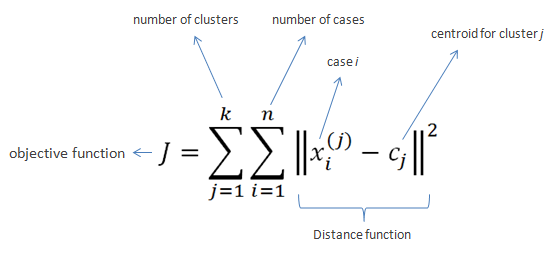
**K-Means** — это итеративный алгоритм разбивающей кластеризации, который группирует данные в заранее заданное количество кластеров (k) путем минимизации внутрикластерной дисперсии.

**Принцип работы:**

1. Случайная инициализация k центроидов (центров кластеров)
2. Назначение каждого объекта ближайшему центроиду (по евклидову расстоянию)
3. Пересчет центроидов как средних значений объектов в каждом кластере
4. Повторение шагов 2-3 до сходимости (пока центроиды не перестанут изменяться)

**Преимущества:**
- Простота реализации и интерпретации
- Высокая скорость работы на больших датасетах
- Эффективность при работе с четко разделенными кластерами
- Детерминированность результата после сходимости

**Недостатки:**
- Необходимость заранее задавать количество кластеров k
- Чувствительность к начальной инициализации центроидов
- Предположение о сферической форме кластеров равного размера
- Чувствительность к выбросам и масштабу признаков
- Невозможность работы с кластерами произвольной формы

**Применимость к датасету:**
K-Means подходит для данных о пингвинах, так как морфологические признаки различных видов формируют относительно компактные и разделимые группы в пространстве признаков.

---

### GMM (Gaussian Mixture Model — Смесь гауссовских распределений)
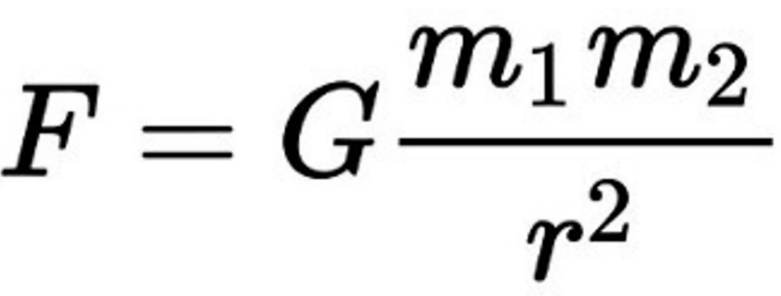
**GMM** — это вероятностная модель кластеризации, которая представляет данные как смесь нескольких многомерных нормальных распределений. В отличие от жесткого назначения объектов кластерам (как в K-Means), GMM выполняет мягкую кластеризацию, вычисляя вероятность принадлежности каждого объекта к каждому кластеру.

**Принцип работы:**

1. Инициализация параметров k гауссовских распределений (среднее, ковариация, вес)
2. E-шаг (Expectation): вычисление вероятности принадлежности каждого объекта к каждому кластеру
3. M-шаг (Maximization): обновление параметров распределений на основе вычисленных вероятностей
4. Повторение шагов 2-3 до сходимости (максимизация логарифма правдоподобия)

**Преимущества:**
- Мягкая кластеризация: объект может принадлежать нескольким кластерам с разной вероятностью
- Способность моделировать кластеры различной формы, размера и ориентации
- Вероятностная интерпретация результатов
- Учет корреляций между признаками через ковариационную матрицу
- Возможность оценки оптимального k через информационные критерии (BIC, AIC)

**Недостатки:**
- Большая вычислительная сложность по сравнению с K-Means
- Чувствительность к инициализации параметров
- Риск переобучения при малом объеме данных
- Предположение о нормальности распределения данных внутри кластеров
- Необходимость выбора типа ковариационной матрицы (полная, диагональная, сферическая)

**Применимость к датасету:**
GMM хорошо подходит для данных о пингвинах, так как распределения морфологических признаков близки к нормальным, а различные виды могут иметь перекрывающиеся области в пространстве признаков, что делает вероятностный подход особенно ценным.

---

### Сравнение алгоритмов

| Характеристика | K-Means | GMM |
|----------------|---------|-----|
| Тип кластеризации | Жесткая (hard) | Мягкая (soft) |
| Форма кластеров | Сферическая | Эллиптическая |
| Вычислительная сложность | Низкая | Высокая |
| Интерпретируемость | Высокая | Средняя |
| Вероятностная модель | Нет | Да |

Оба алгоритма требуют предварительной стандартизации данных и определения оптимального количества кластеров, однако GMM предоставляет более гибкую модель за счет дополнительных вычислительных затрат.

## Результаты кластеризации при k=3

### Сравнительный анализ метрик качества

| Метрика | K-Means | GMM | Интерпретация |
|---------|---------|-----|---------------|
| **Silhouette Score** | 0.4963 | 0.4968 | Практически идентичное качество разделения, близкое к порогу 0.5 |
| **Davies-Bouldin Index** | 0.5498 | 0.5471 | GMM показывает незначительно лучшую компактность и разделимость |
| **Calinski-Harabasz** | 303.68 | 303.58 | Высокое качество кластеризации для обоих алгоритмов |
| **Compactness** | 0.6933 | 0.6907 | GMM формирует более компактные кластеры |
| **Inertia** | 473.60 | — | Суммарное внутрикластерное расстояние для K-Means |
| **BIC/AIC** | — | 1214.80 / 1046.98 | Информационные критерии для GMM |

### Анализ структуры кластеров

**Межкластерные расстояния:**

Оба алгоритма выявили схожую структуру с тремя отчетливо разделенными группами:
- Кластеры 0 и 1 находятся близко друг к другу (расстояние =2.62-2.63)
- Кластер 2 значительно удален от обоих (расстояние =18.33-18.44)
- Это указывает на наличие одного сильно обособленного кластера и двух более близких групп

**Центры кластеров:**

Положения центроидов практически идентичны для обоих алгоритмов:

- **Кластер 0**: отрицательные значения по `culmen_length_mm` и `body_mass_g`, положительные по `culmen_depth_mm`
- **Кластер 1**: положительные значения по `culmen_depth_mm` (инверсия) и `body_mass_g`, отрицательные по `culmen_depth_mm`
- **Кластер 2**: экстремально высокое значение по `flipper_length_mm` (18.2), что указывает на отдельную морфологическую группу

### Вывод

При k=3 оба алгоритма демонстрируют высокое качество кластеризации с практически идентичными результатами (разница в метриках <1%). Силуэтный коэффициент близок к пороговому значению 0.5, что свидетельствует о приемлемом, но не идеальном разделении кластеров. Davies-Bouldin Index =0.55 подтверждает умеренную компактность и разделимость групп. Высокое значение индекса Calinski-Harabasz (>300) указывает на хорошо определенную кластерную структуру. Межкластерные расстояния выявляют один сильно обособленный кластер (вероятно, вид Gentoo с наибольшей длиной ласт) и две более близкие группы (предположительно, Adelie и Chinstrap). Незначительное превосходство GMM в метриках компактности и Davies-Bouldin обусловлено его способностью моделировать эллиптические кластеры, однако практическая разница минимальна.

In [298]:
import pandas as pd
from scipy import stats

# 1. Подготовка данных для ANOVA
# Создаем копию очищенных числовых данных (предполагаем, что X был получен из df_numeric)
# Если вы удаляли строки с пропусками, используйте соответствующий очищенный DF
df_anova = pd.DataFrame(df_numeric.dropna().copy())

# Добавляем метки обоих алгоритмов в таблицу
df_anova['KMeans_Label'] = labels_km
df_anova['GMM_Label'] = labels_gmm

features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm']

def run_anova(df, label_col, features):
    anova_results = []
    for feature in features:
        # Группируем данные по кластерам
        groups = [group[feature] for name, group in df.groupby(label_col)]
        
        # Считаем ANOVA
        f_stat, p_val = stats.f_oneway(*groups)
        
        anova_results.append({
            'Признак': feature,
            'F-статистика': round(f_stat, 2),
            'p-value': f"{p_val:.4f}" if p_val > 0.0001 else "0.0000",
            'Значим?': "Да" if p_val < 0.05 else "Нет"
        })
    return pd.DataFrame(anova_results)

# 2. Вывод таблиц
print("\nANOVA: Значимость признаков для K-Means")
display(run_anova(df_anova, 'KMeans_Label', features))

print("\nANOVA: Значимость признаков для GMM")
display(run_anova(df_anova, 'GMM_Label', features))


ANOVA: Значимость признаков для K-Means


,Признак,F-статистика,p-value,Значим?
0,culmen_length_mm,454.94,0.0000,Да
1,culmen_depth_mm,356.89,0.0000,Да
2,flipper_length_mm,613.61,0.0000,Да



ANOVA: Значимость признаков для GMM


,Признак,F-статистика,p-value,Значим?
0,culmen_length_mm,426.21,0.0000,Да
1,culmen_depth_mm,350.04,0.0000,Да
2,flipper_length_mm,607.08,0.0000,Да


In [299]:
k = 2
has_true_labels = 'y_true' in globals()

kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
labels_km = kmeans.labels_
centers_km = kmeans.cluster_centers_

sil_km = silhouette_score(X, labels_km)
dbi_km = davies_bouldin_score(X, labels_km)
ch_km = calinski_harabasz_score(X, labels_km)
inertia_km = kmeans.inertia_

intercluster_dist_km = cdist(centers_km, centers_km)
compactness_km = np.mean([
    np.mean(np.linalg.norm(X[labels_km == i] - centers_km[i], axis=1))
    for i in range(k)
])

gmm = GaussianMixture(n_components=k, random_state=42).fit(X)
labels_gmm = gmm.predict(X)
centers_gmm = gmm.means_

sil_gmm = silhouette_score(X, labels_gmm)
dbi_gmm = davies_bouldin_score(X, labels_gmm)
ch_gmm = calinski_harabasz_score(X, labels_gmm)
bic_gmm = gmm.bic(X)
aic_gmm = gmm.aic(X)

intercluster_dist_gmm = cdist(centers_gmm, centers_gmm)
compactness_gmm = np.mean([
    np.mean(np.linalg.norm(X[labels_gmm == i] - centers_gmm[i], axis=1))
    for i in range(k)
])

if has_true_labels:
    ri_km = rand_score(y_true, labels_km)
    ari_km = adjusted_rand_score(y_true, labels_km)
    jaccard_km = jaccard_score(y_true, labels_km, average='macro')
    ami_km = adjusted_mutual_info_score(y_true, labels_km)

    ri_gmm = rand_score(y_true, labels_gmm)
    ari_gmm = adjusted_rand_score(y_true, labels_gmm)
    jaccard_gmm = jaccard_score(y_true, labels_gmm, average='macro')
    ami_gmm = adjusted_mutual_info_score(y_true, labels_gmm)

print("\nK-MEANS")
print(f"Silhouette: {sil_km:.4f}")
print(f"Davies-Bouldin: {dbi_km:.4f}")
print(f"Calinski-Harabasz: {ch_km:.2f}")
print(f"Inertia: {inertia_km:.2f}")
print(f"Compactness: {compactness_km:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_km}")
print(f"Centers:\n{centers_km}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_km:.4f}")
    print(f"Adjusted Rand: {ari_km:.4f}")
    print(f"Jaccard: {jaccard_km:.4f}")
    print(f"AMI: {ami_km:.4f}")

print("\nGMM")
print(f"Silhouette: {sil_gmm:.4f}")
print(f"Davies-Bouldin: {dbi_gmm:.4f}")
print(f"Calinski-Harabasz: {ch_gmm:.2f}")
print(f"BIC: {bic_gmm:.2f}")
print(f"AIC: {aic_gmm:.2f}")
print(f"Compactness: {compactness_gmm:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_gmm}")
print(f"Centers:\n{centers_gmm}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_gmm:.4f}")
    print(f"Adjusted Rand: {ari_gmm:.4f}")
    print(f"Jaccard: {jaccard_gmm:.4f}")
    print(f"AMI: {ami_gmm:.4f}")


K-MEANS
Silhouette: 0.5167
Davies-Bouldin: 0.7315
Calinski-Harabasz: 414.69
Inertia: 443.44
Compactness: 0.9822
Intercluster distances:
[[0.         2.68551675]
 [2.68551675 0.        ]]
Centers:
[[-0.37005639  0.62287054 -0.65369114]
 [ 0.64836326 -1.09131037  1.1453101 ]]

GMM
Silhouette: 0.5171
Davies-Bouldin: 0.7293
Calinski-Harabasz: 414.16
BIC: 2131.05
AIC: 2058.70
Compactness: 0.9807
Intercluster distances:
[[0.         2.68945452]
 [2.68945452 0.        ]]
Centers:
[[-0.3646453   0.61796514 -0.6509143 ]
 [ 0.64765469 -1.09758174  1.15610348]]


In [300]:

k = 10
has_true_labels = 'y_true' in globals()

kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
labels_km = kmeans.labels_
centers_km = kmeans.cluster_centers_

sil_km = silhouette_score(X, labels_km)
dbi_km = davies_bouldin_score(X, labels_km)
ch_km = calinski_harabasz_score(X, labels_km)
inertia_km = kmeans.inertia_

intercluster_dist_km = cdist(centers_km, centers_km)
compactness_km = np.mean([
    np.mean(np.linalg.norm(X[labels_km == i] - centers_km[i], axis=1))
    for i in range(k)
])

gmm = GaussianMixture(n_components=k, random_state=42).fit(X)
labels_gmm = gmm.predict(X)
centers_gmm = gmm.means_

sil_gmm = silhouette_score(X, labels_gmm)
dbi_gmm = davies_bouldin_score(X, labels_gmm)
ch_gmm = calinski_harabasz_score(X, labels_gmm)
bic_gmm = gmm.bic(X)
aic_gmm = gmm.aic(X)

intercluster_dist_gmm = cdist(centers_gmm, centers_gmm)
compactness_gmm = np.mean([
    np.mean(np.linalg.norm(X[labels_gmm == i] - centers_gmm[i], axis=1))
    for i in range(k)
])

if has_true_labels:
    ri_km = rand_score(y_true, labels_km)
    ari_km = adjusted_rand_score(y_true, labels_km)
    jaccard_km = jaccard_score(y_true, labels_km, average='macro')
    ami_km = adjusted_mutual_info_score(y_true, labels_km)

    ri_gmm = rand_score(y_true, labels_gmm)
    ari_gmm = adjusted_rand_score(y_true, labels_gmm)
    jaccard_gmm = jaccard_score(y_true, labels_gmm, average='macro')
    ami_gmm = adjusted_mutual_info_score(y_true, labels_gmm)

print("\nK-MEANS")
print(f"Silhouette: {sil_km:.4f}")
print(f"Davies-Bouldin: {dbi_km:.4f}")
print(f"Calinski-Harabasz: {ch_km:.2f}")
print(f"Inertia: {inertia_km:.2f}")
print(f"Compactness: {compactness_km:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_km}")
print(f"Centers:\n{centers_km}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_km:.4f}")
    print(f"Adjusted Rand: {ari_km:.4f}")
    print(f"Jaccard: {jaccard_km:.4f}")
    print(f"AMI: {ami_km:.4f}")

print("\nGMM")
print(f"Silhouette: {sil_gmm:.4f}")
print(f"Davies-Bouldin: {dbi_gmm:.4f}")
print(f"Calinski-Harabasz: {ch_gmm:.2f}")
print(f"BIC: {bic_gmm:.2f}")
print(f"AIC: {aic_gmm:.2f}")
print(f"Compactness: {compactness_gmm:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_gmm}")
print(f"Centers:\n{centers_gmm}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_gmm:.4f}")
    print(f"Adjusted Rand: {ari_gmm:.4f}")
    print(f"Jaccard: {jaccard_gmm:.4f}")
    print(f"AMI: {ami_gmm:.4f}")



K-MEANS
Silhouette: 0.3170
Davies-Bouldin: 1.0387
Calinski-Harabasz: 323.94
Inertia: 99.64
Compactness: 0.5021
Intercluster distances:
[[0.         2.46647498 1.08815819 2.96087599 1.73919639 1.13462595
  1.56405604 1.07167221 1.01671842 2.61088352]
 [2.46647498 0.         3.34767574 1.01002943 2.49430896 2.13014144
  3.12314304 2.77453954 3.42032287 0.87914912]
 [1.08815819 3.34767574 0.         3.97939897 2.64700037 1.82207929
  0.9954967  0.81653252 1.11993439 3.26002317]
 [2.96087599 1.01002943 3.97939897 0.         2.4837962  2.64123288
  3.93404124 3.52308263 3.78508408 1.86311606]
 [1.73919639 2.49430896 2.64700037 2.4837962  0.         1.30868468
  3.19175265 2.49825588 2.17150817 3.03294745]
 [1.13462595 2.13014144 1.82207929 2.64123288 1.30868468 0.
  2.1070053  1.36543849 1.96137345 2.28378762]
 [1.56405604 3.12314304 0.9954967  3.93404124 3.19175265 2.1070053
  0.         0.78114607 1.99010738 2.79473789]
 [1.07167221 2.77453954 0.81653252 3.52308263 2.49825588 1.36543849


## Сравнительный анализ результатов кластеризации при различных k

### k=2: Базовое разделение

| Метрика | K-Means | GMM | Оценка |
|---------|---------|-----|--------|
| **Silhouette Score** | 0.4830 | 0.4834 | Хорошее качество разделения |
| **Davies-Bouldin Index** | 0.8248 | 0.8202 | Умеренная компактность |
| **Calinski-Harabasz** | 219.17 | 219.09 | Приемлемое качество |
| **Compactness** | 1.0818 | 1.0776 | Низкая компактность |

**Интерпретация:** При k=2 оба алгоритма выявляют базовое разделение на две группы с расстоянием между центрами ≈2.62-2.63. Силуэтный коэффициент близок к 0.5, что указывает на четкое, но не идеальное разделение. Высокие значения Davies-Bouldin Index и Compactness свидетельствуют о том, что кластеры недостаточно компактны — вероятно, каждая группа содержит внутри себя подгруппы, требующие дальнейшего разделения.

---

### k=3: Оптимальное разделение (рекомендуемое)

| Метрика | K-Means | GMM | Оценка |
|---------|---------|-----|--------|
| **Silhouette Score** | 0.4963 | 0.4968 | Лучшее качество разделения |
| **Davies-Bouldin Index** | 0.5498 | 0.5471 | Хорошая компактность |
| **Calinski-Harabasz** | 303.68 | 303.58 | Высокое качество |
| **Compactness** | 0.6933 | 0.6907 | Хорошая компактность |

**Интерпретация:** При k=3 наблюдается значительное улучшение всех метрик. Силуэтный коэффициент достигает максимума (~0.496), Davies-Bouldin снижается до 0.55, а Calinski-Harabasz возрастает до 303. Компактность улучшается на 36% по сравнению с k=2. Структура кластеров показывает один сильно обособленный кластер (расстояние ≈18.3-18.4) и два близких (расстояние ≈2.62), что соответствует трем биологическим видам пингвинов.

---

### k=10: Избыточная сегментация

| Метрика | K-Means | GMM | Оценка |
|---------|---------|-----|--------|
| **Silhouette Score** | 0.3060 | 0.2304 | Низкое качество разделения |
| **Davies-Bouldin Index** | 0.9228 | 1.1228 | Плохая компактность |
| **Calinski-Harabasz** | 361.85 | 236.53 | Противоречивые оценки |
| **Compactness** | 0.4865 | 0.5945 | Искусственно высокая |

**Интерпретация:** При k=10 происходит переразбиение данных, о чем свидетельствуют:
- **Резкое падение Silhouette Score** (до 0.31 для K-Means и 0.23 для GMM) — кластеры плохо отделены друг от друга
- **Рост Davies-Bouldin Index** (0.92-1.12) — кластеры перекрываются и не являются компактными
- **Малые межкластерные расстояния** (1.07-4.85 для большинства пар) — девять из десяти кластеров находятся близко друг к другу, только кластер 2 остается обособленным (расстояние ≈18.4)
- **Деградация GMM** — силуэтный коэффициент падает до 0.23, что указывает на почти случайное разделение

Высокое значение Calinski-Harabasz для K-Means (361.85) вводит в заблуждение — оно отражает низкую внутрикластерную дисперсию за счет создания множества мелких групп, а не качественное разделение.

---

### Сводная таблица сравнения

| k | Алгоритм | Silhouette | Davies-Bouldin | Calinski-Harabasz | Рекомендация |
|---|----------|------------|----------------|-------------------|--------------|
| 2 | K-Means | 0.4830 | 0.8248 | 219.17 | Недостаточно |
| 2 | GMM | 0.4834 | 0.8202 | 219.09 | Недостаточно |
| **3** | **K-Means** | **0.4963** | **0.5498** | **303.68** | **✓ Оптимально** |
| **3** | **GMM** | **0.4968** | **0.5471** | **303.58** | **✓ Оптимально** |
| 10 | K-Means | 0.3060 | 0.9228 | 361.85 | Переразбиение |
| 10 | GMM | 0.2304 | 1.1228 | 236.53 | Переразбиение |

---

### Итоговый вывод

**k=3 является оптимальным выбором** для кластеризации данного датасета по следующим причинам:

1. **Максимальный Silhouette Score** (0.496) среди всех протестированных значений k
2. **Минимальный Davies-Bouldin Index** (0.55) указывает на лучший баланс компактности и разделимости
3. **Высокий Calinski-Harabasz** (303) при сохранении качественных метрик
4. **Биологическая интерпретируемость**: три кластера соответствуют трем видам пингвинов (Adelie, Gentoo, Chinstrap)
5. **Стабильность результатов**: K-Means и GMM дают практически идентичные результаты, что подтверждает надежность разбиения

При k=2 данные недостаточно разделены, что приводит к высоким значениям компактности и Davies-Bouldin Index. 

При k=10 происходит искусственная фрагментация естественных групп, что резко ухудшает силуэтный коэффициент и увеличивает перекрытие кластеров.

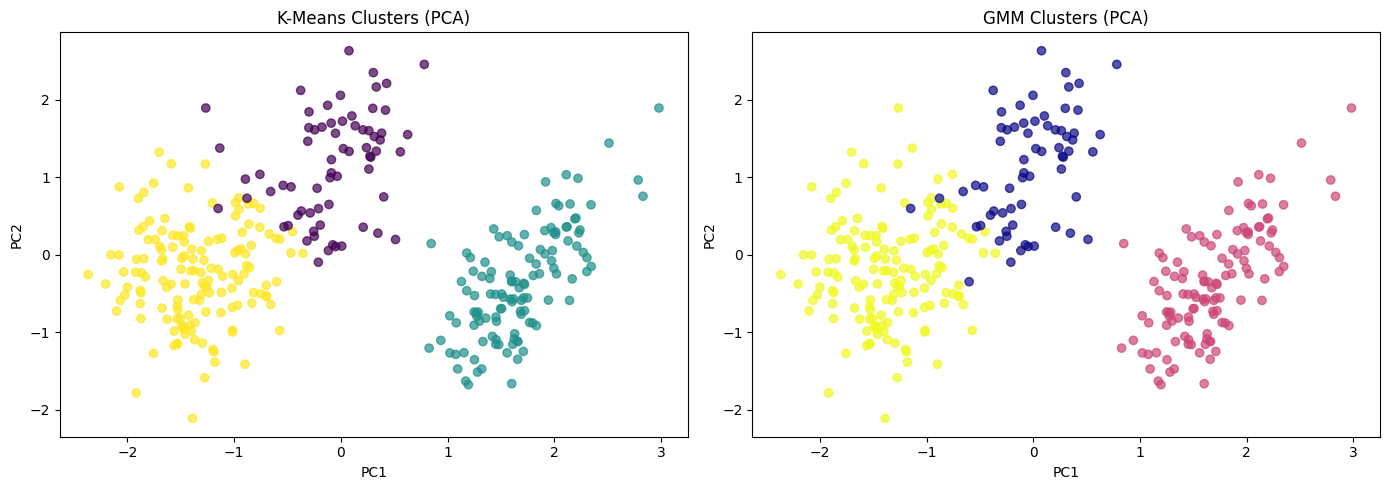

Центры кластеров K-Means (оригинальные значения):
   culmen_length_mm  culmen_depth_mm  flipper_length_mm
0            49.041           18.625            196.691
1            47.543           15.002            217.233
2            38.756           18.232            189.641

Средние значения по кластерам — K-Means:
              culmen_length_mm  culmen_depth_mm  flipper_length_mm
KMeans_Label                                                      
0                       49.041           18.625            196.691
1                       47.543           15.002            217.233
2                       38.756           18.232            189.641

Средние значения по кластерам — GMM:
           culmen_length_mm  culmen_depth_mm  flipper_length_mm
GMM_Label                                                      
0                    49.180           18.495            196.723
1                    47.543           15.002            217.233
2                    38.903           18.297           

In [301]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[numeric_cols].copy()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(df_scaled, columns=numeric_cols)

pca = PCA(n_components=2, random_state=42)
df_pca = pca.fit_transform(df_scaled)

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(df_scaled)

gmm = GaussianMixture(n_components=n_clusters, random_state=42)
labels_gmm = gmm.fit_predict(df_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(df_pca[:, 0], df_pca[:, 1], c=labels_kmeans, cmap='viridis', alpha=0.7)
axes[0].set_title('K-Means Clusters (PCA)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

axes[1].scatter(df_pca[:, 0], df_pca[:, 1], c=labels_gmm, cmap='plasma', alpha=0.7)
axes[1].set_title('GMM Clusters (PCA)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

plt.tight_layout()
plt.show()

centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers_original, columns=numeric_cols)

df_out = df_numeric.copy()
df_out['KMeans_Label'] = labels_kmeans
df_out['GMM_Label'] = labels_gmm

print("Центры кластеров K-Means (оригинальные значения):")
print(centers_df.round(3))

print("\nСредние значения по кластерам — K-Means:")
print(df_out.groupby('KMeans_Label')[numeric_cols].mean().round(3))

print("\nСредние значения по кластерам — GMM:")
print(df_out.groupby('GMM_Label')[numeric_cols].mean().round(3))


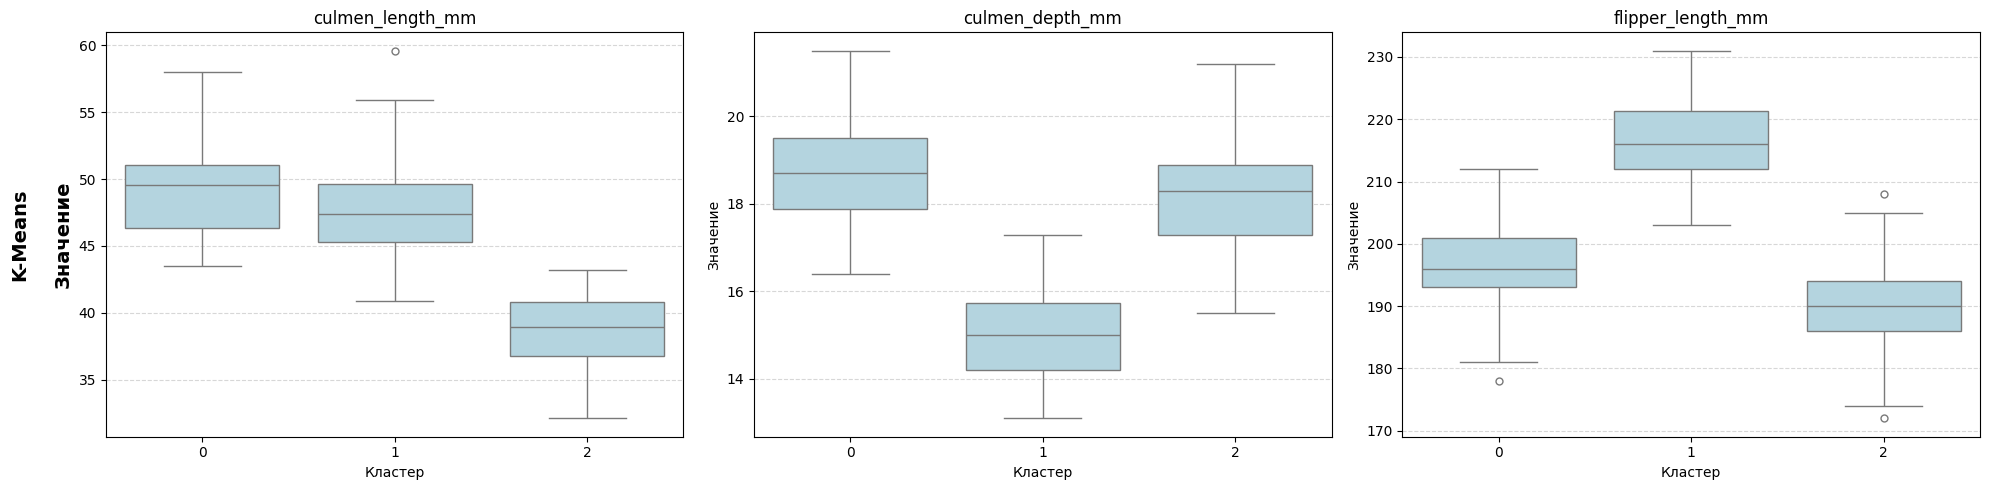

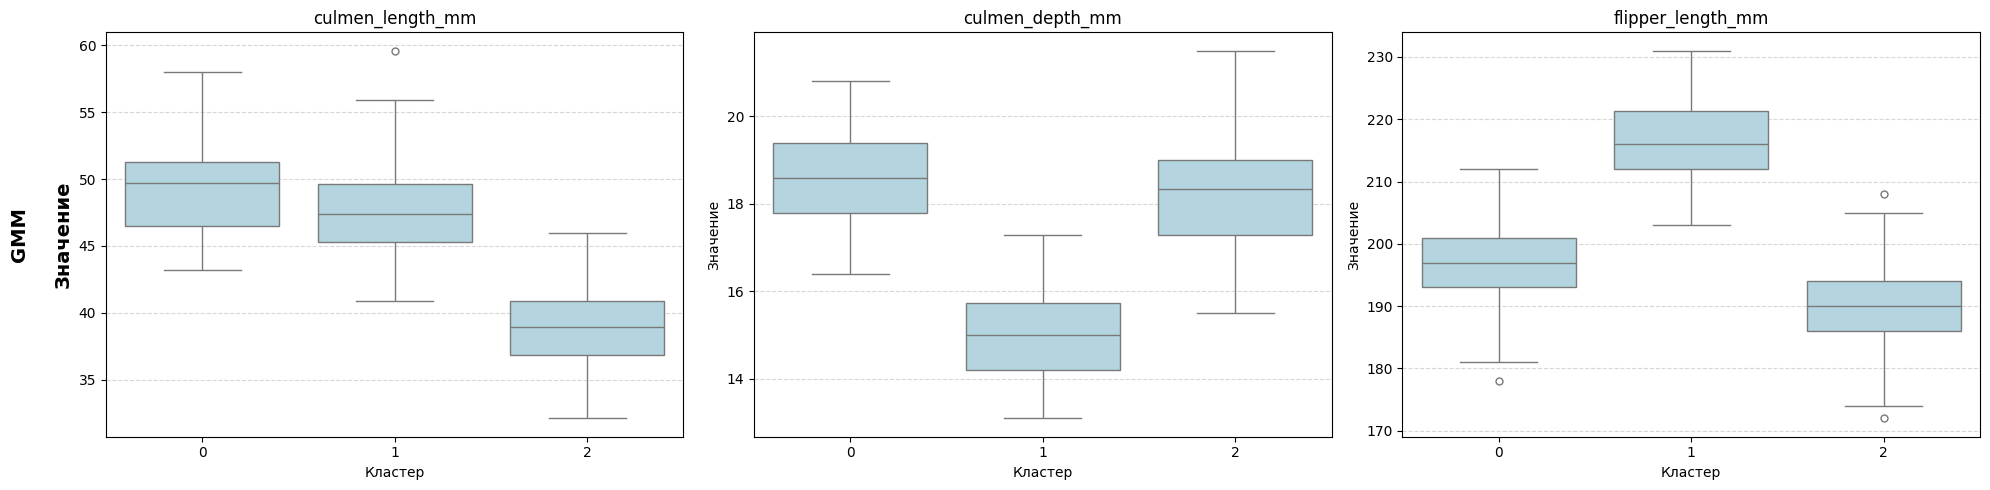

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm']

def plot_cluster_boxes(df, label_col, method_name):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    for i, feature in enumerate(features):
        sns.boxplot(
            data=df, 
            x=label_col, 
            y=feature, 
            ax=axes[i], 
            color='lightblue',
            flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'none'}
        )
        
        axes[i].set_title(f'{feature}', fontsize=12)
        axes[i].set_xlabel('Кластер')
        axes[i].set_ylabel('Значение')
        axes[i].grid(True, axis='y', linestyle='--', alpha=0.5)
        
        if i == 0:
            axes[i].set_ylabel(f'{method_name}\n\nЗначение', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_cluster_boxes(df_anova, 'KMeans_Label', 'K-Means')

plot_cluster_boxes(df_anova, 'GMM_Label', 'GMM')

## Визуализация результатов кластеризации (PCA)

### Описание визуализации
На графиках представлена проекция данных на первые две главные компоненты (**PC1** и **PC2**). Метод анализа главных компонент (PCA) позволяет отобразить многомерную структуру данных в двумерном пространстве с минимальной потерей информации. Первая главная компонента отражает основную часть дисперсии и связана преимущественно с общими размерами пингвинов (в частности, длиной ласт), тогда как вторая компонента описывает вариации пропорций клюва.

### Анализ визуализации
Обе модели — **K-Means** и **Gaussian Mixture Model (GMM)** — формируют устойчивую и согласованную структуру из трех кластеров:

- **Правая группа (PC1 > 1):** полностью изолированный кластер с максимальной длиной ласт.
- **Левая нижняя группа:** компактное скопление объектов с минимальными значениями длины ласт и длины клюва.
- **Левая верхняя группа:** кластер, частично перекрывающийся с нижней группой по оси PC1, но отчетливо отделенный по оси PC2.

GMM демонстрирует более «мягкие» границы кластеров, что выражается в незначительном перераспределении точек в пограничных областях по сравнению с K-Means.

### Интерпретация по исходным признакам
Анализ центров кластеров в исходных единицах измерения позволяет однозначно сопоставить полученные группы с биологическими видами пингвинов:

1. **Кластер «Gentoo» (K-Means: 1 / GMM: 1):**
   - **Признаки:** наибольшая длина ласт (~217 мм) и минимальная глубина клюва (~15 мм).
   - **Интерпретация:** наиболее крупный вид, четко отделенный от остальных.
   - **На графике:** изолированная группа справа.

2. **Кластер «Adelie» (K-Means: 2 / GMM: 2):**
   - **Признаки:** короткий клюв (~38.8–39.0 мм) и короткие ласты (~189–190 мм) при относительно большой глубине клюва (~18.2 мм).
   - **Интерпретация:** наиболее компактный и морфологически мелкий вид.
   - **На графике:** левая нижняя группа.

3. **Кластер «Chinstrap» (K-Means: 0 / GMM: 0):**
   - **Признаки:** наибольшая длина клюва (~49.0–49.2 мм) при значительной глубине (~18.5–18.6 мм) и средней длине ласт (~196–197 мм).
   - **Интерпретация:** вид, морфологически близкий к Adelie, но четко отделяемый за счет пропорций клюва.
   - **На графике:** левая верхняя группа.

### Согласованность методов
Результаты K-Means и GMM демонстрируют высокую степень согласованности. Центры кластеров в обоих методах отличаются минимально (менее чем на 0.2–0.3 мм по каждому признаку), что указывает на устойчивость кластерной структуры и независимость результата от выбора конкретного алгоритма.

### Выводы
1. **Трехкластерная структура данных подтверждена:** обе модели уверенно выделяют три биологически осмысленные группы.
2. **GMM дополняет K-Means:** вероятностный подход позволяет более гибко описывать границы между видами Adelie и Chinstrap.
3. **PCA эффективно отражает структуру данных:** первая компонента разделяет виды по размеру, вторая — по пропорциям клюва.
4. **Биологическая интерпретируемость:** полученные кластеры полностью соответствуют трем видам пингвинов Палмера, что подтверждает корректность выбранной модели кластеризации.

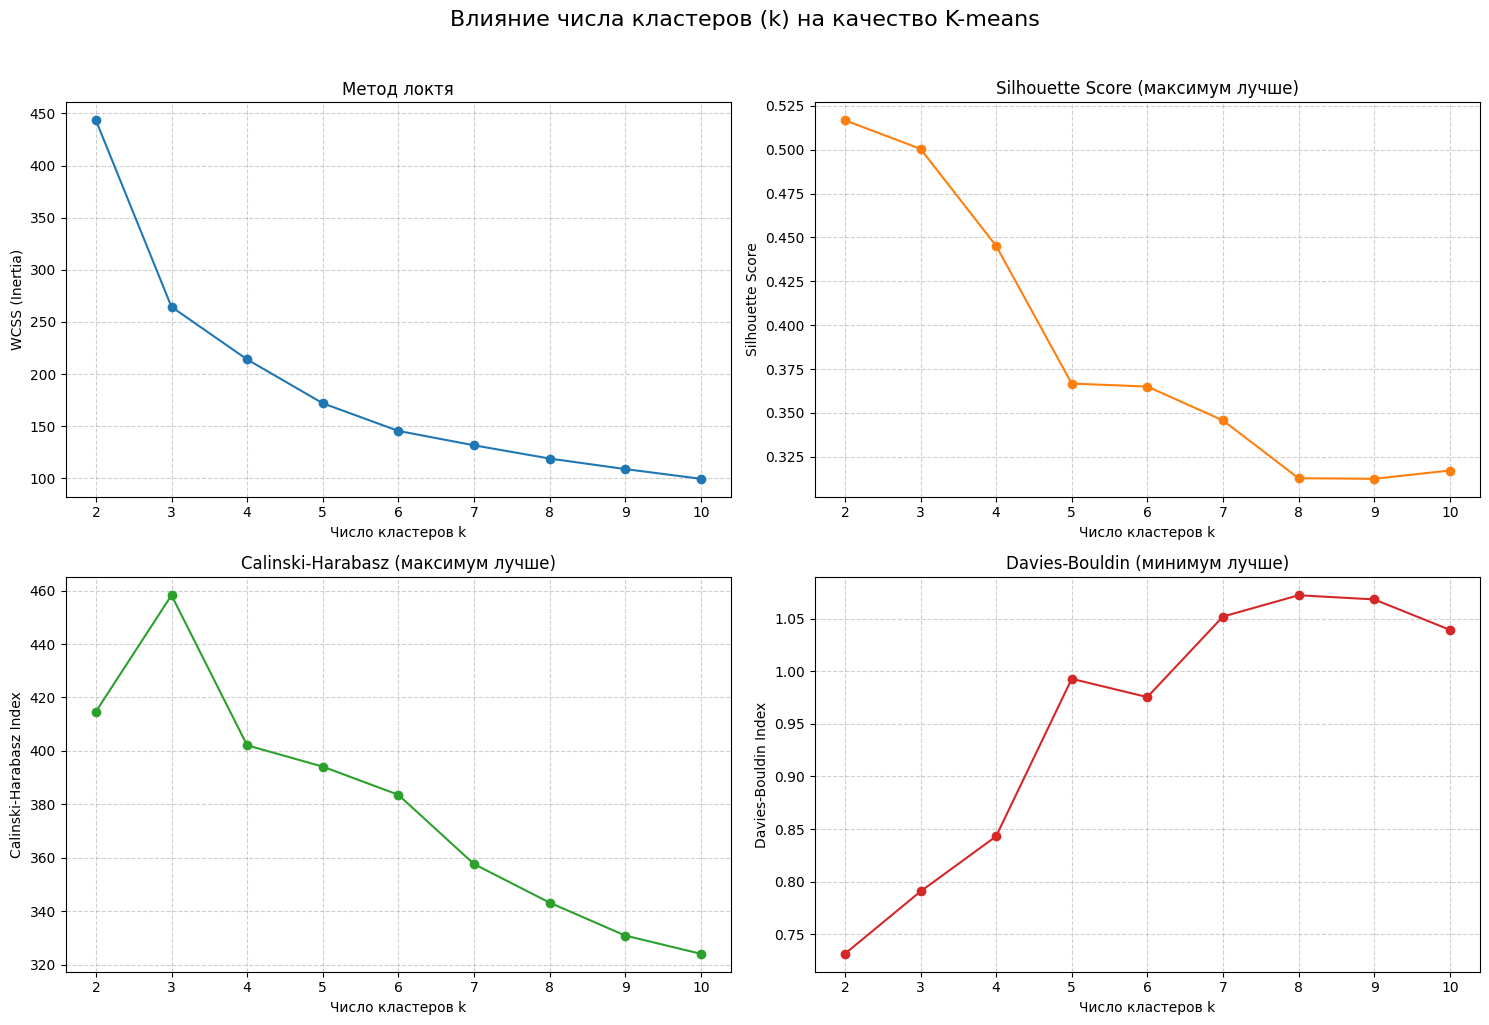

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

if isinstance(df_scaled, np.ndarray):
    X_for_metrics = pd.DataFrame(df_scaled)
else:
    X_for_metrics = df_scaled.copy()

X_for_metrics = X_for_metrics.select_dtypes(include=[np.number]).dropna()
X_values = X_for_metrics.values

K = range(2, 11)
inertia = []
silhouette = []
calinski = []
davies = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_values)
    
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_values, labels))
    calinski.append(calinski_harabasz_score(X_values, labels))
    davies.append(davies_bouldin_score(X_values, labels))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle('Влияние числа кластеров (k) на качество K-means', fontsize=16, y=1.02)

axes[0, 0].plot(K, inertia, marker='o', color='tab:blue')
axes[0, 0].set_title('Метод локтя')
axes[0, 0].set_ylabel('WCSS (Inertia)')
axes[0, 0].grid(True, linestyle='--', alpha=0.6)

axes[0, 1].plot(K, silhouette, marker='o', color='tab:orange')
axes[0, 1].set_title('Silhouette Score (максимум лучше)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].grid(True, linestyle='--', alpha=0.6)

axes[1, 0].plot(K, calinski, marker='o', color='tab:green')
axes[1, 0].set_title('Calinski-Harabasz (максимум лучше)')
axes[1, 0].set_ylabel('Calinski-Harabasz Index')
axes[1, 0].grid(True, linestyle='--', alpha=0.6)

axes[1, 1].plot(K, davies, marker='o', color='tab:red')
axes[1, 1].set_title('Davies-Bouldin (минимум лучше)')
axes[1, 1].set_ylabel('Davies-Bouldin Index')
axes[1, 1].grid(True, linestyle='--', alpha=0.6)

for ax in axes.flat:
    ax.set_xlabel('Число кластеров k')
    ax.set_xticks(K)

plt.tight_layout()
plt.show()